# Normal vs. Segmented Model Performance Comparison

This notebook compares the performance of models that have both normal and segmented versions in the VIDORE benchmark. The goal is to analyze whether image segmentation improves model performance across different metrics and datasets.

In [30]:
import os
import json
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from IPython.display import display, Markdown

# Set the style for our plots
plt.style.use('ggplot')
sns.set_palette("colorblind")
plt.rcParams['figure.figsize'] = [12, 8]

## Load Model Results

First, we'll gather all metrics files from both the normal and segmented directories.

In [31]:
# Define the results directories
normal_dir = "./results/normal/"
segmented_dir = "./results/segmented/"

# Function to find metrics files in a directory
def find_metrics_files(directory):
    metrics_files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('_metrics.json'):
                metrics_files.append(os.path.join(root, file))
    return metrics_files

# Get all metrics files
normal_files = find_metrics_files(normal_dir)
segmented_files = find_metrics_files(segmented_dir)

print(f"Found {len(normal_files)} metrics files in normal directory")
print(f"Found {len(segmented_files)} metrics files in segmented directory")

Found 78 metrics files in normal directory
Found 52 metrics files in segmented directory


## Extract Model Information

We need to extract structured information about each model, including whether it's normal or segmented, and the base model name.

In [32]:
# Identify normal and segmented versions of the same model
def extract_model_info(model_path):
    # Extract model type (normal or segmented) and name from the path
    path_parts = model_path.split('/')
    model_type = None
    
    # Find whether this is normal or segmented
    for part in path_parts:
        if part == 'normal' or part == 'segmented':
            model_type = part
            break
    
    # Extract full model name from directory 
    model_dir = [p for p in path_parts if p != 'results' and p != 'normal' and p != 'segmented' and 'vidore_' not in p][-1]
    
    # Extract base model name (removing segmentation info if present)
    base_model_name = re.sub(r'_seg_\d+x\d+(?:_overlap_\d+)?$', '', model_dir)
    
    # Extract segmentation pattern if present
    seg_pattern = None
    if '_seg_' in model_dir:
        seg_match = re.search(r'_seg_(\d+x\d+)(?:_overlap_(\d+))?', model_dir)
        if seg_match:
            grid = seg_match.group(1)
            overlap = seg_match.group(2) if seg_match.lastindex >= 2 else None
            seg_pattern = f"{grid}" + (f"_overlap_{overlap}" if overlap else "")
    
    # Extract dataset information from filename
    file_name = os.path.basename(model_path)
    dataset_match = re.search(r'vidore_([^_]+)', file_name)
    dataset = dataset_match.group(1) if dataset_match else None
    
    return {
        'full_path': model_path,
        'model_type': model_type,  # 'normal' or 'segmented'
        'dir_name': model_dir,
        'base_name': base_model_name,
        'seg_pattern': seg_pattern,
        'dataset': dataset
    }

In [33]:
# Process all files
all_files = normal_files + segmented_files
model_info_list = [extract_model_info(file) for file in all_files]

# Create a DataFrame for easier filtering
model_info_df = pd.DataFrame(model_info_list)
model_info_df.head()

,full_path,model_type,dir_name,base_name,seg_pattern,dataset
0,./results/normal/blip2-flan-t5-xl/merged_datas...,normal,merged_dataset_metrics.json,merged_dataset_metrics.json,None,None
1,./results/normal/blip2-flan-t5-xl/vidore_arxiv...,normal,blip2-flan-t5-xl,blip2-flan-t5-xl,None,arxivqa
2,./results/normal/blip2-flan-t5-xl/vidore_docvq...,normal,blip2-flan-t5-xl,blip2-flan-t5-xl,None,docvqa
3,./results/normal/blip2-flan-t5-xl/vidore_infov...,normal,blip2-flan-t5-xl,blip2-flan-t5-xl,None,infovqa
4,./results/normal/blip2-flan-t5-xl/vidore_shift...,normal,blip2-flan-t5-xl,blip2-flan-t5-xl,None,shiftproject


## Find Models with Both Normal and Segmented Versions

We'll identify models that have both normal and segmented versions for the same dataset.

In [34]:
# Group by base_name and dataset to find matching pairs
model_groups = model_info_df.groupby(['base_name', 'dataset'])

# Filter to find groups with both normal and segmented versions
paired_models = []

for (base_name, dataset), group in model_groups:
    has_normal = 'normal' in group['model_type'].values
    has_segmented = 'segmented' in group['model_type'].values
    
    if has_normal and has_segmented:
        paired_models.append({
            'base_name': base_name,
            'dataset': dataset,
            'normal_path': group[group['model_type'] == 'normal']['full_path'].values[0],
            'segmented_paths': group[group['model_type'] == 'segmented']['full_path'].values.tolist(),
            'segmentation_patterns': group[group['model_type'] == 'segmented']['seg_pattern'].values.tolist()
        })

# Convert to DataFrame for easier manipulation
paired_df = pd.DataFrame(paired_models)

print(f"Found {len(paired_df)} model-dataset combinations with both normal and segmented versions")
paired_df.head()

Found 31 model-dataset combinations with both normal and segmented versions


,base_name,dataset,normal_path,segmented_paths,segmentation_patterns
0,blip_Salesforce_blip-vqa-base,arxivqa,./results/normal/blip_Salesforce_blip-vqa-base...,[./results/segmented/blip_Salesforce_blip-vqa-...,[2x2]
1,blip_Salesforce_blip-vqa-base,docvqa,./results/normal/blip_Salesforce_blip-vqa-base...,[./results/segmented/blip_Salesforce_blip-vqa-...,[2x2]
2,blip_Salesforce_blip-vqa-base,infovqa,./results/normal/blip_Salesforce_blip-vqa-base...,[./results/segmented/blip_Salesforce_blip-vqa-...,[2x2]
3,blip_Salesforce_blip-vqa-base,shiftproject,./results/normal/blip_Salesforce_blip-vqa-base...,[./results/segmented/blip_Salesforce_blip-vqa-...,[2x2]
4,blip_Salesforce_blip-vqa-base,syntheticDocQA,./results/normal/blip_Salesforce_blip-vqa-base...,[./results/segmented/blip_Salesforce_blip-vqa-...,"[2x2, 2x2, 2x2, 2x2]"


In [35]:
set(paired_df['base_name'])

{'blip_Salesforce_blip-vqa-base',
 'clip_openai_clip-vit-base-patch32',
 'jina-clip-v1_jinaai_jina-clip-v1',
 'llava-interleave_llava-hf_llava-interleave-qwen-0.5b-hf',
 'siglip_google_siglip-so400m-patch14-384',
 'vit_google_vit-base-patch16-224-in21k'}

In [36]:
set(paired_df["dataset"])

{'arxivqa',
 'docvqa',
 'infovqa',
 'shiftproject',
 'syntheticDocQA',
 'tabfquad',
 'tatdqa'}

In [37]:
paired_df = paired_df[paired_df["dataset"].isin(["arxivqa", "docvqa", "tabfquad", "tatdqa"])]

In [38]:
paired_df

,base_name,dataset,normal_path,segmented_paths,segmentation_patterns
0,blip_Salesforce_blip-vqa-base,arxivqa,./results/normal/blip_Salesforce_blip-vqa-base...,[./results/segmented/blip_Salesforce_blip-vqa-...,[2x2]
1,blip_Salesforce_blip-vqa-base,docvqa,./results/normal/blip_Salesforce_blip-vqa-base...,[./results/segmented/blip_Salesforce_blip-vqa-...,[2x2]
5,blip_Salesforce_blip-vqa-base,tabfquad,./results/normal/blip_Salesforce_blip-vqa-base...,[./results/segmented/blip_Salesforce_blip-vqa-...,[2x2]
6,blip_Salesforce_blip-vqa-base,tatdqa,./results/normal/blip_Salesforce_blip-vqa-base...,[./results/segmented/blip_Salesforce_blip-vqa-...,[2x2]
7,clip_openai_clip-vit-base-patch32,arxivqa,./results/normal/clip_openai_clip-vit-base-pat...,[./results/segmented/clip_openai_clip-vit-base...,[2x2]
8,clip_openai_clip-vit-base-patch32,docvqa,./results/normal/clip_openai_clip-vit-base-pat...,[./results/segmented/clip_openai_clip-vit-base...,[2x2]
12,clip_openai_clip-vit-base-patch32,tabfquad,./results/normal/clip_openai_clip-vit-base-pat...,[./results/segmented/clip_openai_clip-vit-base...,[2x2]
13,clip_openai_clip-vit-base-patch32,tatdqa,./results/normal/clip_openai_clip-vit-base-pat...,[./results/segmented/clip_openai_clip-vit-base...,[2x2]
14,jina-clip-v1_jinaai_jina-clip-v1,arxivqa,./results/normal/jina-clip-v1_jinaai_jina-clip...,[./results/segmented/jina-clip-v1_jinaai_jina-...,[2x2]
15,jina-clip-v1_jinaai_jina-clip-v1,docvqa,./results/normal/jina-clip-v1_jinaai_jina-clip...,[./results/segmented/jina-clip-v1_jinaai_jina-...,[2x2]


## Extract Metrics for Comparison

Now we'll load the metrics data for each model pair.

In [39]:
# Function to load metrics from a file path
def load_metrics(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)
    
    metrics = None
    if 'metrics' in data:
        dataset_key = list(data['metrics'].keys())[0] if data['metrics'] else None
        if dataset_key:
            metrics = data['metrics'][dataset_key]
    
    return metrics

# Metrics we're interested in comparing
metric_types = ['ndcg', 'map', 'recall', 'precision']
k_values = [1, 3, 5, 10, 20, 50, 100]

# Create a DataFrame to store comparison data
comparison_data = []

for _, row in paired_df.iterrows():
    base_name = row['base_name']
    dataset = row['dataset']
    
    # Load normal metrics
    normal_metrics = load_metrics(row['normal_path'])
    
    # For each segmented version
    for i, seg_path in enumerate(row['segmented_paths']):
        seg_pattern = row['segmentation_patterns'][i] if i < len(row['segmentation_patterns']) else None
        segmented_metrics = load_metrics(seg_path)
        
        # Skip if either metrics couldn't be loaded
        if not normal_metrics or not segmented_metrics:
            continue
        
        # Compare all relevant metrics
        for metric_type in metric_types:
            for k in k_values:
                metric_key = f"{metric_type}_at_{k}"
                
                if metric_key in normal_metrics and metric_key in segmented_metrics:
                    normal_value = normal_metrics[metric_key]
                    segmented_value = segmented_metrics[metric_key]
                    
                    # Calculate improvement percentage
                    if normal_value > 0:
                        improvement_pct = (segmented_value - normal_value) / normal_value * 100
                    else:
                        improvement_pct = np.nan if normal_value == 0 else float('inf')
                    
                    comparison_data.append({
                        'Base Model': base_name,
                        'Dataset': dataset,
                        'Segmentation Pattern': seg_pattern,
                        'Metric': metric_type,
                        'k': k,
                        'Normal Value': normal_value,
                        'Segmented Value': segmented_value,
                        'Absolute Difference': segmented_value - normal_value,
                        'Improvement (%)': improvement_pct
                    })

# Convert to DataFrame
comparison_df = pd.DataFrame(comparison_data)
comparison_df.head()

,Base Model,Dataset,Segmentation Pattern,Metric,k,Normal Value,Segmented Value,Absolute Difference,Improvement (%)
0,blip_Salesforce_blip-vqa-base,arxivqa,2x2,ndcg,1,0.00200,0.00200,0.00000,0.000000
1,blip_Salesforce_blip-vqa-base,arxivqa,2x2,ndcg,3,0.00452,0.00400,-0.00052,-11.504425
2,blip_Salesforce_blip-vqa-base,arxivqa,2x2,ndcg,5,0.00539,0.00564,0.00025,4.638219
3,blip_Salesforce_blip-vqa-base,arxivqa,2x2,ndcg,10,0.00994,0.00894,-0.00100,-10.060362
4,blip_Salesforce_blip-vqa-base,arxivqa,2x2,ndcg,20,0.01480,0.01531,0.00051,3.445946


In [64]:
print(comparison_df.head())

                      Base Model  Dataset Segmentation Pattern Metric   k  \
0  blip_Salesforce_blip-vqa-base  arxivqa                  2x2   ndcg   1   
1  blip_Salesforce_blip-vqa-base  arxivqa                  2x2   ndcg   3   
2  blip_Salesforce_blip-vqa-base  arxivqa                  2x2   ndcg   5   
3  blip_Salesforce_blip-vqa-base  arxivqa                  2x2   ndcg  10   
4  blip_Salesforce_blip-vqa-base  arxivqa                  2x2   ndcg  20   

   Normal Value  Segmented Value  Absolute Difference  Improvement (%)  
0       0.00200          0.00200              0.00000         0.000000  
1       0.00452          0.00400             -0.00052       -11.504425  
2       0.00539          0.00564              0.00025         4.638219  
3       0.00994          0.00894             -0.00100       -10.060362  
4       0.01480          0.01531              0.00051         3.445946  


In [41]:
comparison_df = comparison_df.fillna(0.000001)

In [65]:
# 首先筛选出我们需要的指标
selected_metrics = ['ndcg', 'map'] #, 'precision', 'recall']
k_values = [3, 5, 10]

# 筛选原始数据
filtered_df = comparison_df[
    (comparison_df['Metric'].isin(selected_metrics)) & 
    (comparison_df['k'].isin(k_values))
]

# 对筛选后的数据进行透视
pivot_df = filtered_df.pivot_table(
    index=['Base Model', 'k'],
    columns=['Dataset', 'Metric'],
    values=['Normal Value', 'Segmented Value']
)

pivot_df = pivot_df.fillna(0.0000001)

# 计算增长率
for dataset in filtered_df['Dataset'].unique():
    for metric in selected_metrics:
        pivot_df[('Growth Rate (%)', dataset, metric)] = (
            (pivot_df[('Segmented Value', dataset, metric)] - 
             pivot_df[('Normal Value', dataset, metric)]) / 
            pivot_df[('Normal Value', dataset, metric)] * 100
        )

# 重新组织列的多级索引
new_columns = []
for k in k_values:
    for metric in selected_metrics:
        new_columns.append(('Growth Rate (%)', f"{metric}@{k}"))
        # new_columns.append(('Segmented Value', f"{metric}@{k}"))

# 创建新的DataFrame
result_df = pd.DataFrame(columns=pd.MultiIndex.from_tuples(new_columns))

# 填充数据
for model in filtered_df['Base Model'].unique():
    row_data = {}
    for k in k_values:
        for metric in selected_metrics:
            growth_rate = 0
            normal_val = 0
            segmented_val = 0
            count = 0
            for dataset in filtered_df['Dataset'].unique():
                try:
                    # 获取normal值
                    normal_val = pivot_df.loc[(model, k), ('Normal Value', dataset, metric)]
                    # 获取segmented值
                    segmented_val = pivot_df.loc[(model, k), ('Segmented Value', dataset, metric)]
                    # 计算增长率
                    if normal_val != 0:
                        growth_rate += ((segmented_val - normal_val) / normal_val * 100)
                        count += 1
                except KeyError:
                    continue
            
            if count > 0:
                row_data[('Growth Rate (%)', f"{metric}@{k}")] = growth_rate / count
                # row_data[('Segmented Value', f"{metric}@{k}")] = segmented_val / count
            else:
                row_data[('Growth Rate (%)', f"{metric}@{k}")] = float('nan')
                # row_data[('Segmented Value', f"{metric}@{k}")] = 0
    
    result_df.loc[model] = row_data

# 重置索引
result_df = result_df.reset_index(drop=True)
result_df.index = filtered_df['Base Model'].unique()

In [66]:
print(result_df.reset_index())

                                               index Growth Rate (%)  \
                                                              ndcg@3   
0                      blip_Salesforce_blip-vqa-base      -10.628756   
1                  clip_openai_clip-vit-base-patch32       59.599957   
2                   jina-clip-v1_jinaai_jina-clip-v1      143.564117   
3  llava-interleave_llava-hf_llava-interleave-qwe...      -19.474638   
4            siglip_google_siglip-so400m-patch14-384       -6.677956   
5              vit_google_vit-base-patch16-224-in21k       57.560575   

                                                               
        map@3      ndcg@5       map@5     ndcg@10      map@10  
0  -10.630200    0.310777   -3.085420   -7.624803   -6.972214  
1   64.987621   38.356951   48.328693   33.550816   43.599565  
2  150.769505  134.742886  144.038640  121.665826  136.256219  
3  -16.147069  -18.619666  -16.479845   -8.349648  -10.328760  
4   -7.011335   -6.052978   -6.636861  

In [67]:
result_df.reset_index()

index Growth Rate (%)  \
                                                              ndcg@3   
0                      blip_Salesforce_blip-vqa-base      -10.628756   
1                  clip_openai_clip-vit-base-patch32       59.599957   
2                   jina-clip-v1_jinaai_jina-clip-v1      143.564117   
3  llava-interleave_llava-hf_llava-interleave-qwe...      -19.474638   
4            siglip_google_siglip-so400m-patch14-384       -6.677956   
5              vit_google_vit-base-patch16-224-in21k       57.560575   

                                                               
        map@3      ndcg@5       map@5     ndcg@10      map@10  
0  -10.630200    0.310777   -3.085420   -7.624803   -6.972214  
1   64.987621   38.356951   48.328693   33.550816   43.599565  
2  150.769505  134.742886  144.038640  121.665826  136.256219  
3  -16.147069  -18.619666  -16.479845   -8.349648  -10.328760  
4   -7.011335   -6.052978   -6.636861   -5.515351   -6.404461  
5   72.566430   14.634766   32.413363   19.540038   31.289937

In [68]:
print(result_df.reset_index())

                                               index Growth Rate (%)  \
                                                              ndcg@3   
0                      blip_Salesforce_blip-vqa-base      -10.628756   
1                  clip_openai_clip-vit-base-patch32       59.599957   
2                   jina-clip-v1_jinaai_jina-clip-v1      143.564117   
3  llava-interleave_llava-hf_llava-interleave-qwe...      -19.474638   
4            siglip_google_siglip-so400m-patch14-384       -6.677956   
5              vit_google_vit-base-patch16-224-in21k       57.560575   

                                                               
        map@3      ndcg@5       map@5     ndcg@10      map@10  
0  -10.630200    0.310777   -3.085420   -7.624803   -6.972214  
1   64.987621   38.356951   48.328693   33.550816   43.599565  
2  150.769505  134.742886  144.038640  121.665826  136.256219  
3  -16.147069  -18.619666  -16.479845   -8.349648  -10.328760  
4   -7.011335   -6.052978   -6.636861  

## Visualize Performance Comparisons

### Overall Distribution of Improvements

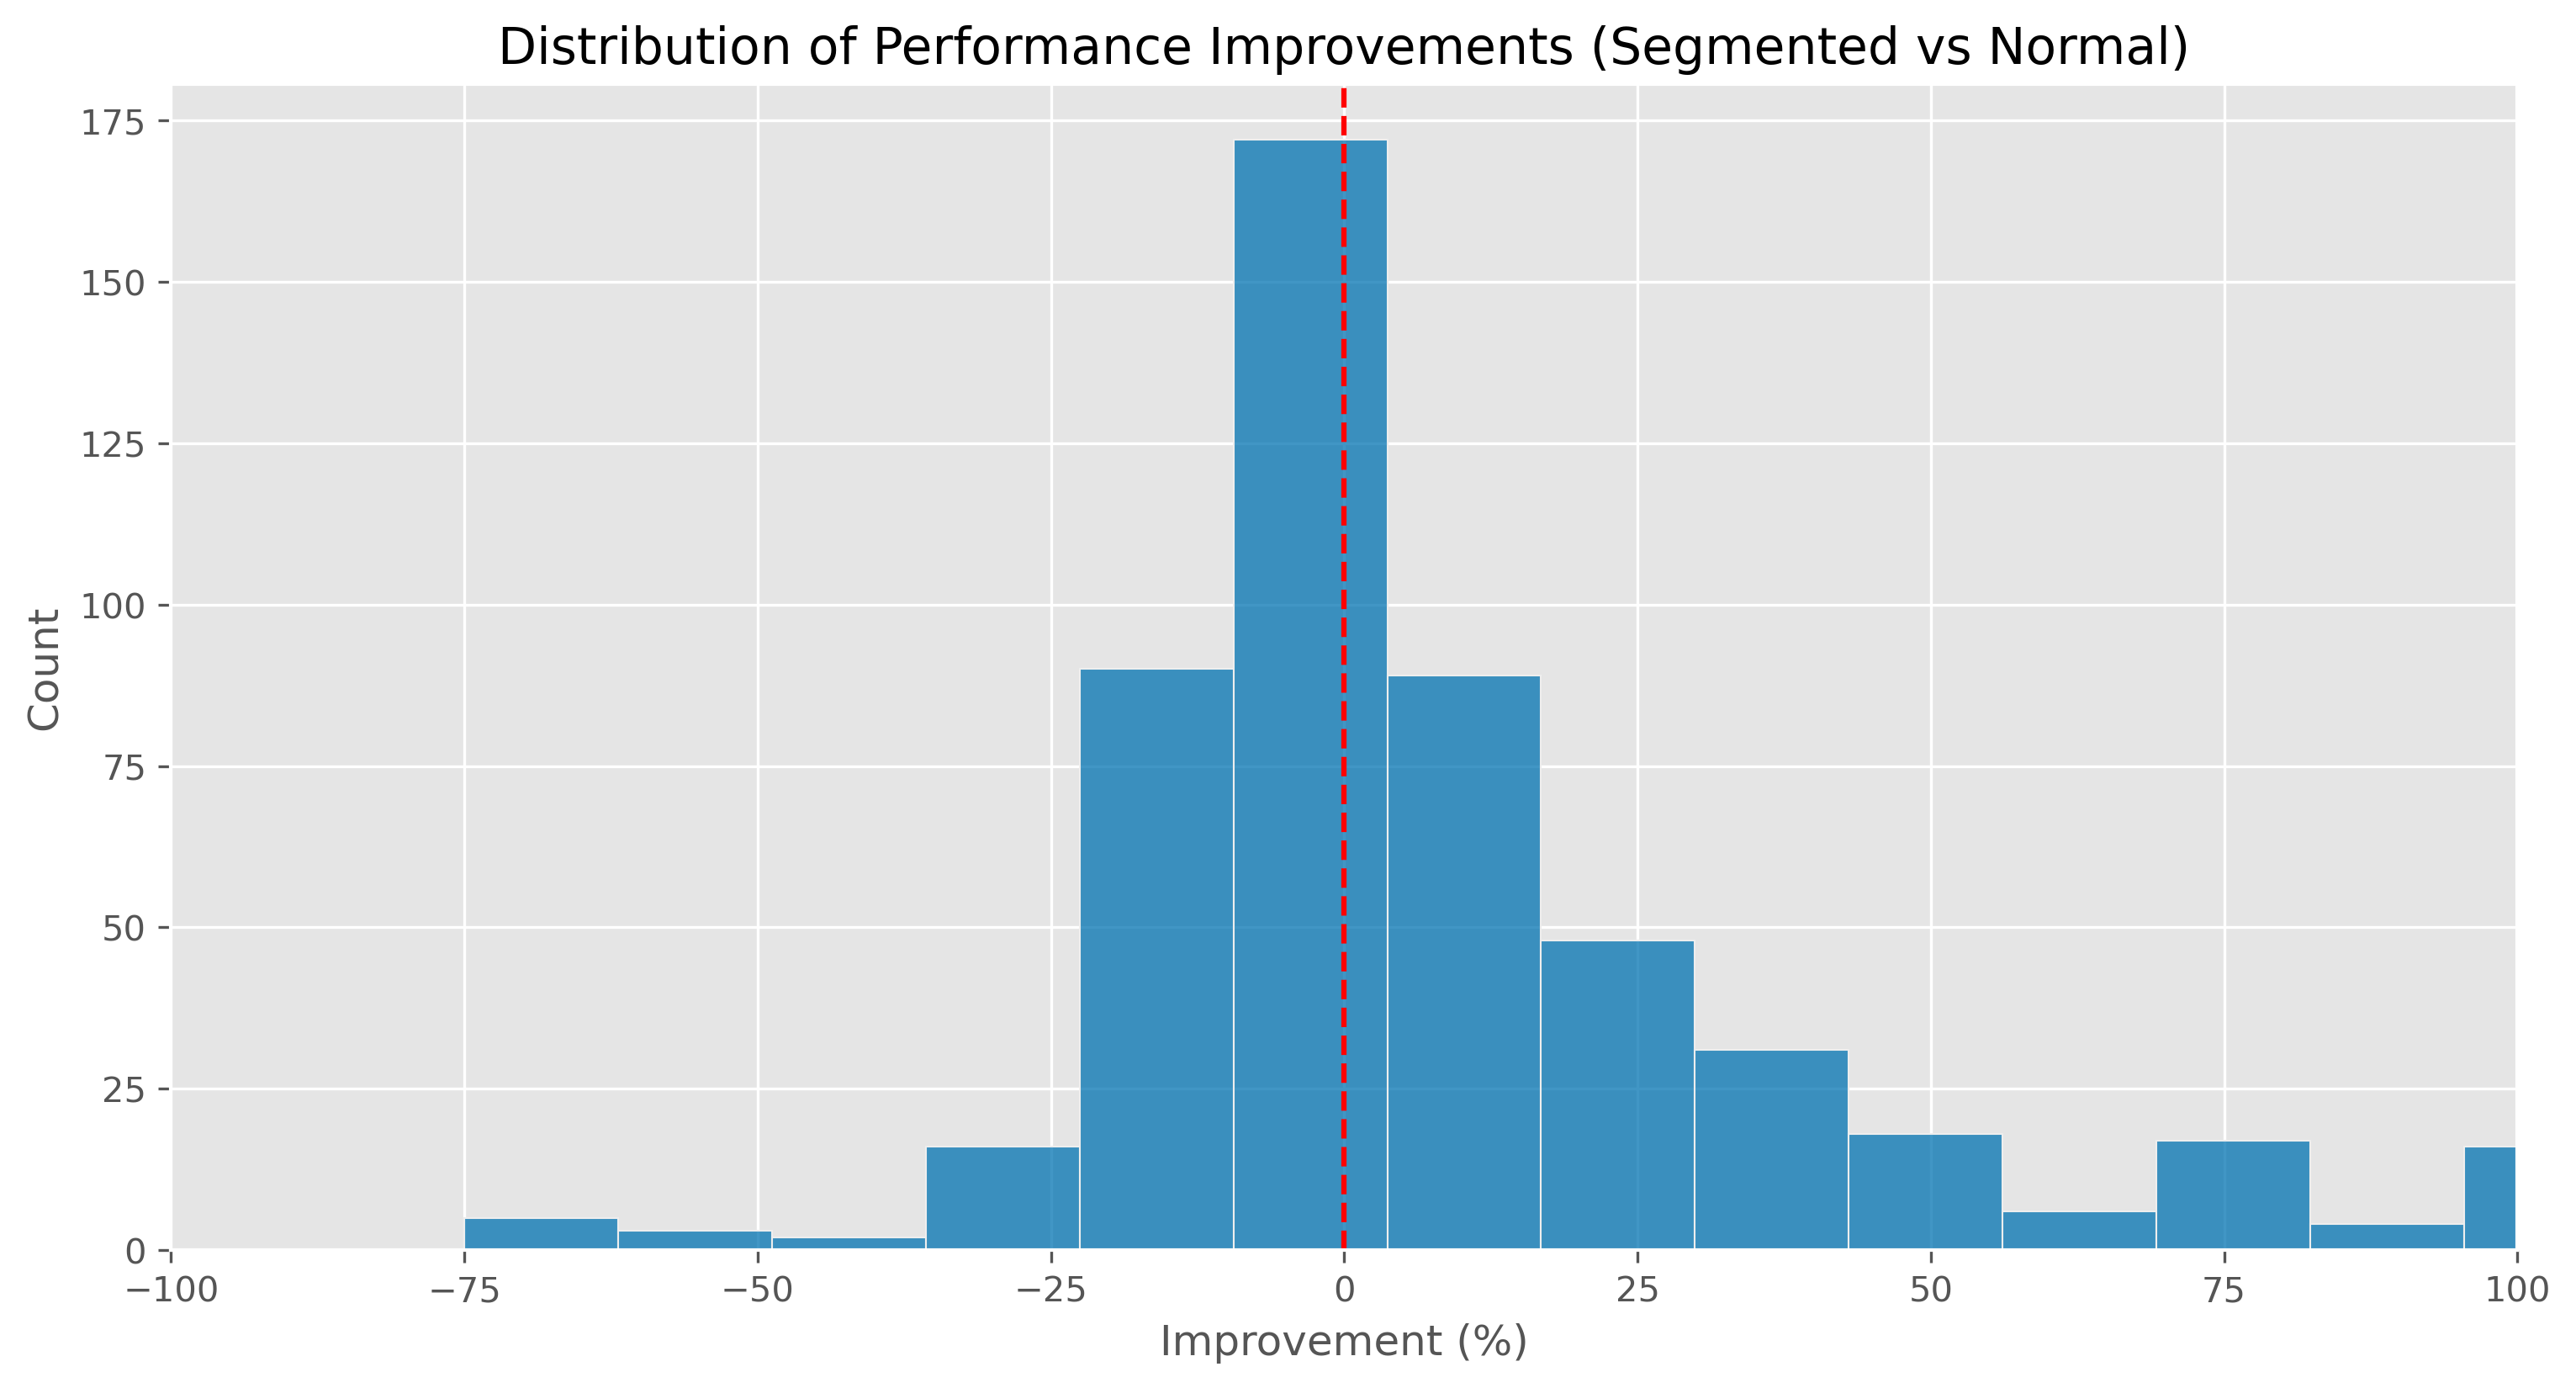

count    560.000000
mean      32.974356
std       96.260837
min      -75.000000
25%       -7.381346
50%        2.494288
75%       27.239399
max      580.569620
Name: Improvement (%), dtype: float64

In [69]:
# Plot histogram of improvement percentages
plt.figure(figsize=(12, 6), dpi=300)
sns.histplot(comparison_df['Improvement (%)'].dropna(), bins=50)
plt.axvline(x=0, color='r', linestyle='--')
plt.title('Distribution of Performance Improvements (Segmented vs Normal)')
plt.xlabel('Improvement (%)')
plt.ylabel('Count')
plt.xlim(-100, 100)  # Focus on reasonable improvement range
plt.show()

# Summary statistics
improvement_stats = comparison_df['Improvement (%)'].describe()
display(improvement_stats)

### Performance by Metric and k Value

In [70]:
# Calculate average improvement by metric type and k value
metric_k_improvement = comparison_df.groupby(['Metric', 'k'])['Improvement (%)'].mean().reset_index()
metric_k_improvement

,Metric,k,Improvement (%)
0,map,1,79.530983
1,map,3,50.906990
2,map,5,39.715714
3,map,10,37.488057
4,map,20,33.474017
5,map,50,29.405060
6,map,100,27.503228
7,ndcg,1,79.530983
8,ndcg,3,44.788660
9,ndcg,5,32.674547


In [71]:
metric_k_improvement = metric_k_improvement[metric_k_improvement['k'].isin([3, 5, 10])]

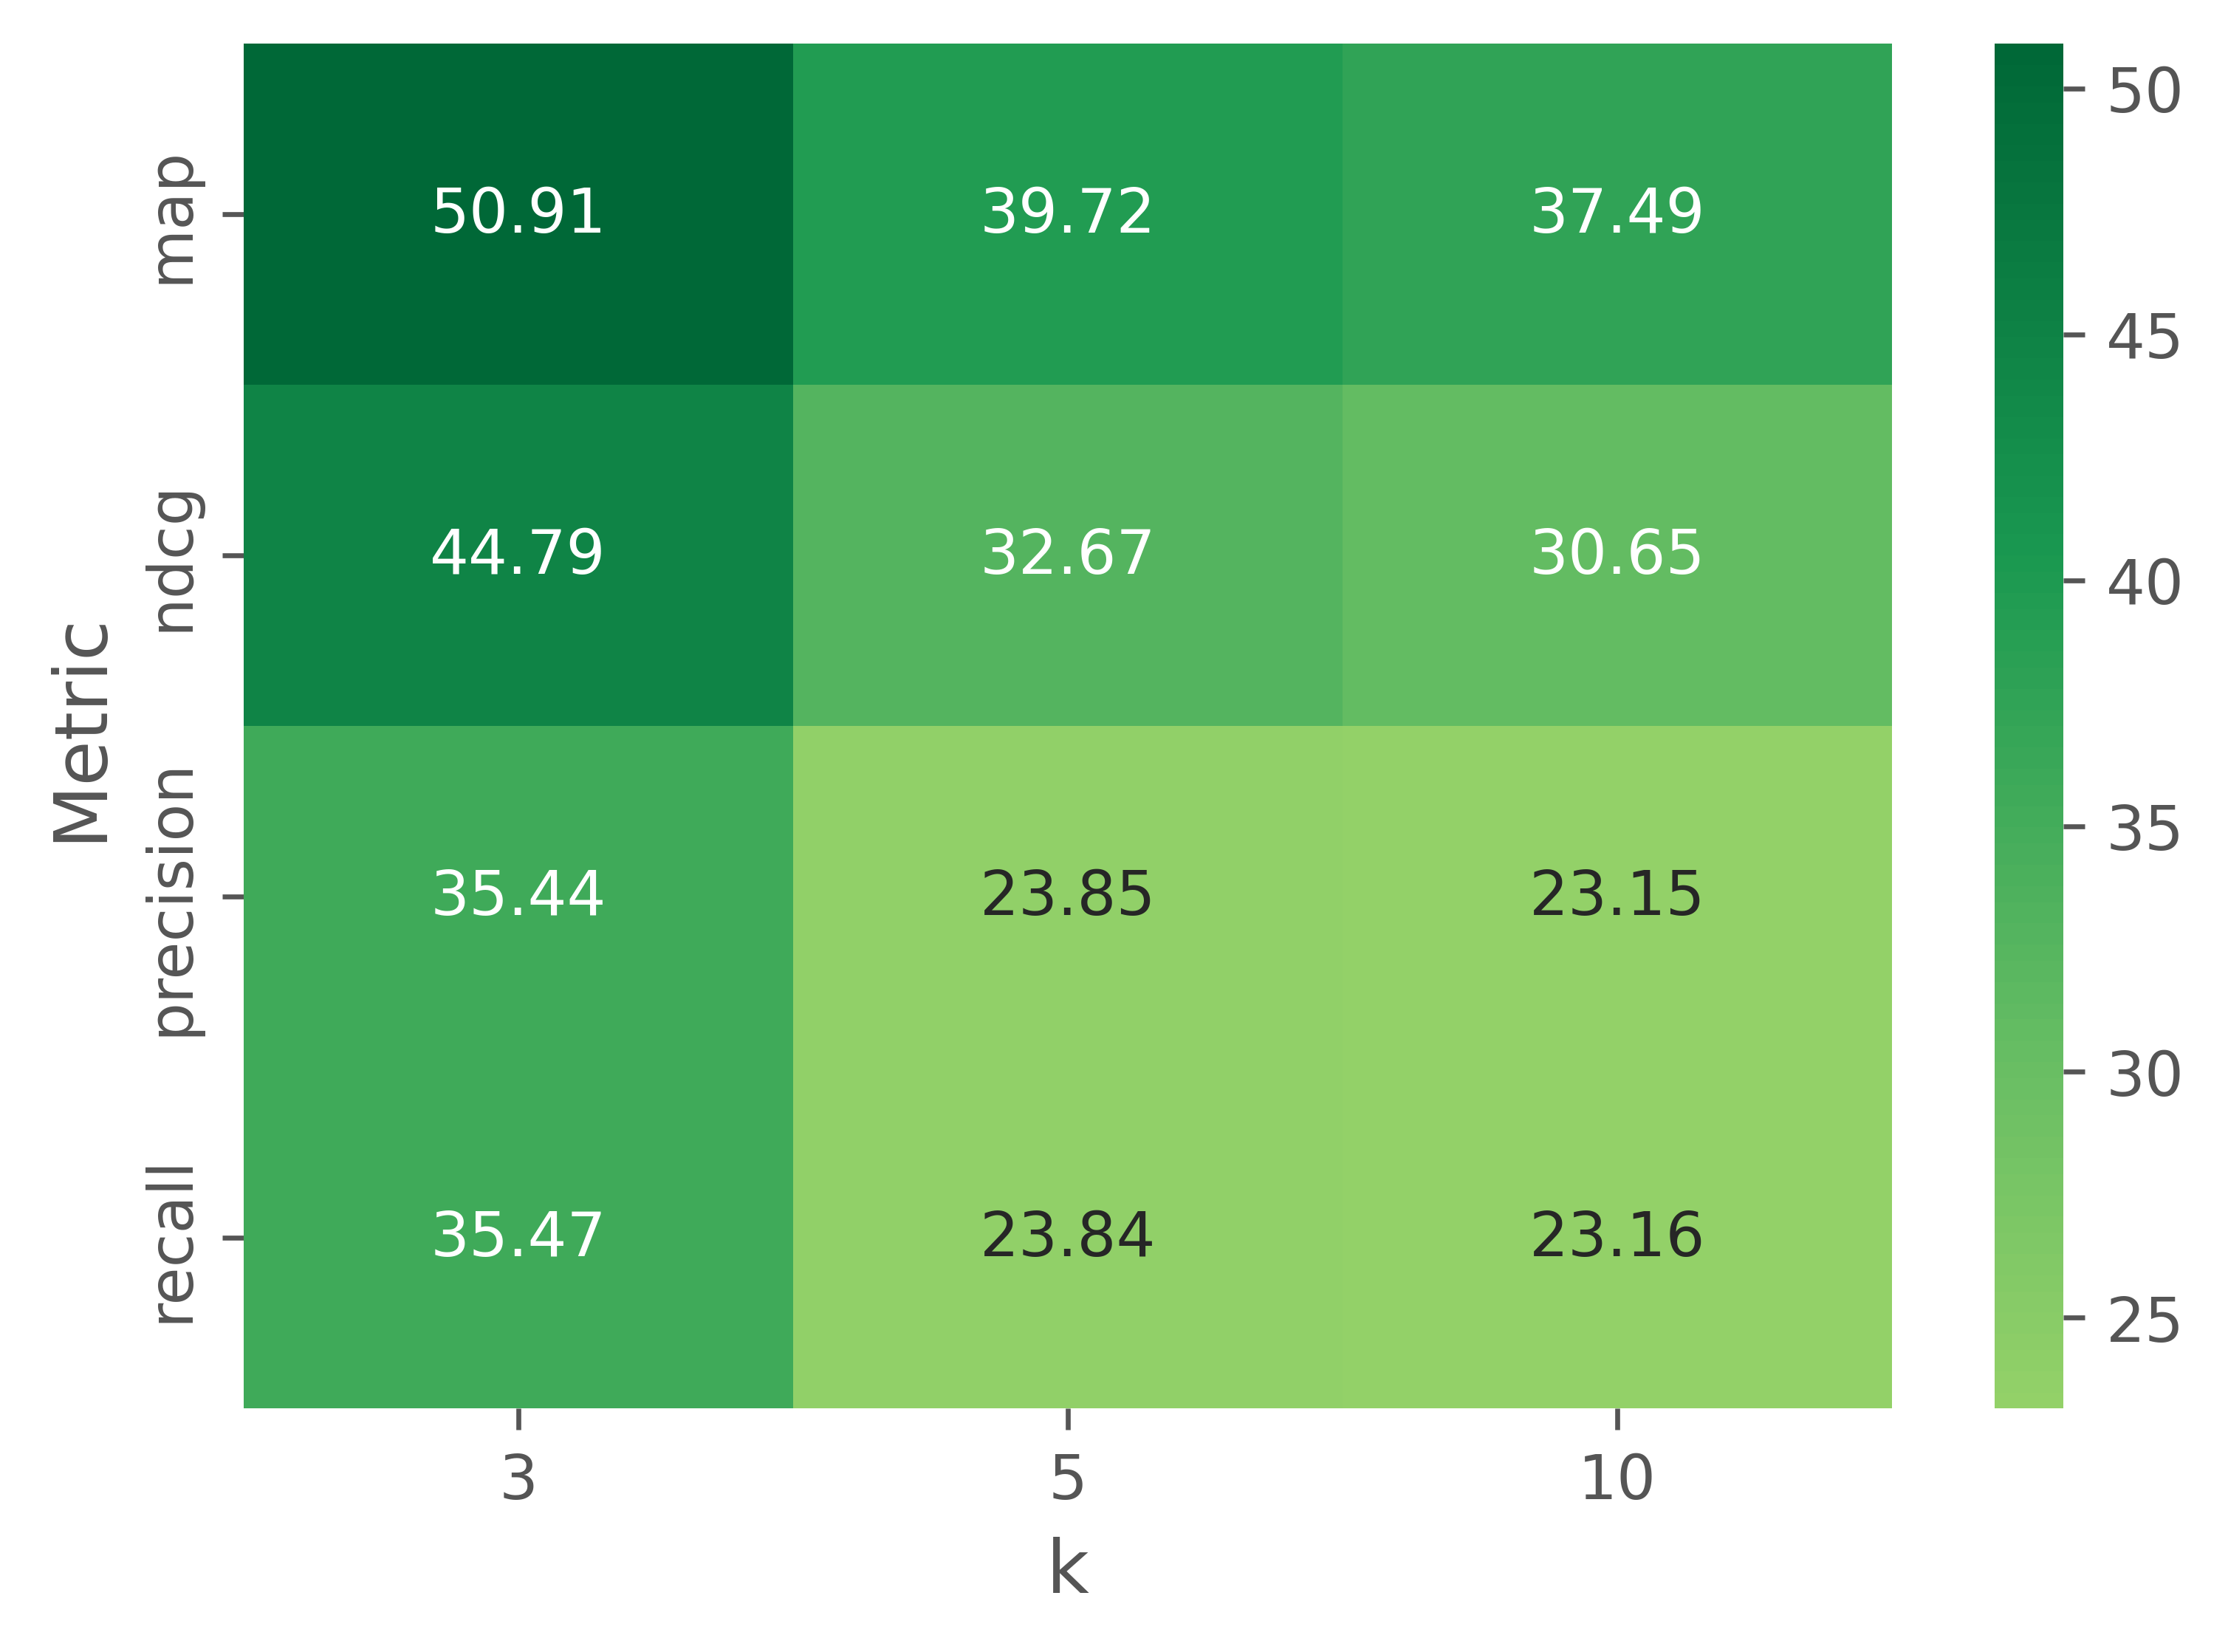

In [72]:
# Plot heatmap
pivot_improvement = metric_k_improvement.pivot(index='Metric', columns='k', values='Improvement (%)')
plt.figure(figsize=(6, 4), dpi=600)
sns.heatmap(pivot_improvement, annot=True, cmap='RdYlGn', center=0, fmt='.2f')
# plt.title('Average Performance Improvement by Metric and k Value (%)')
plt.savefig("./figs/improvement-heatmap.png")
plt.show()

### Performance by Model

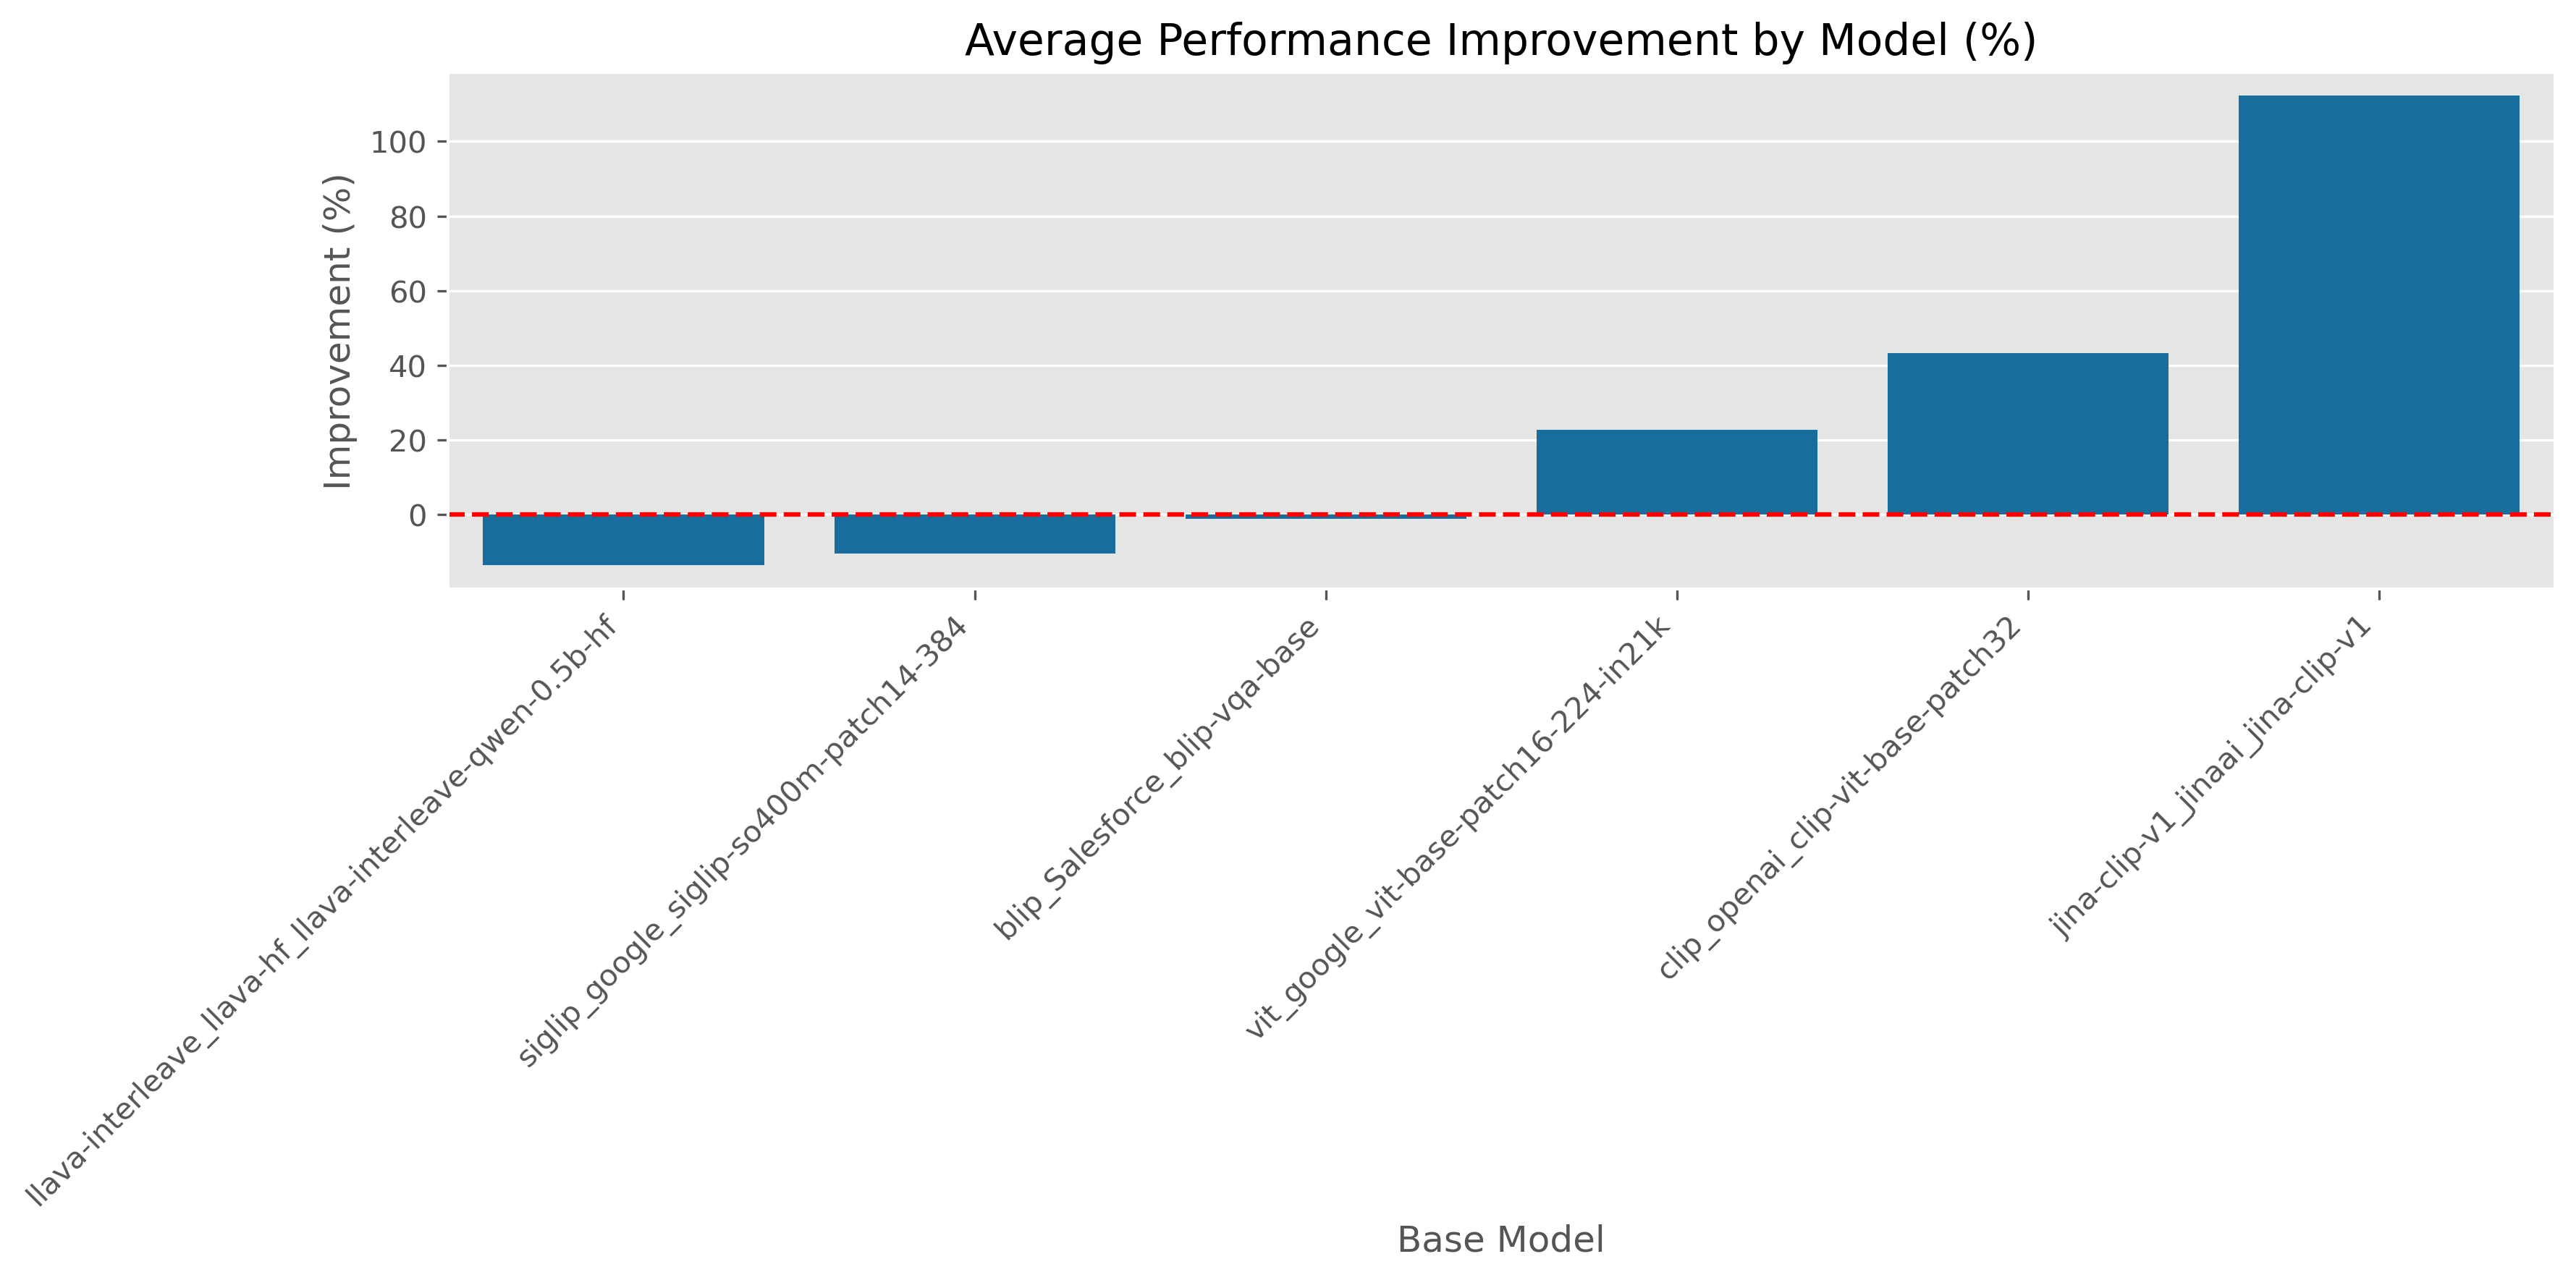

In [49]:
# Calculate average improvement by model
model_improvement = comparison_df.groupby('Base Model')['Improvement (%)'].mean().reset_index().sort_values('Improvement (%)')

plt.figure(figsize=(12, 6), dpi=300)
sns.barplot(data=model_improvement, x='Base Model', y='Improvement (%)')
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Average Performance Improvement by Model (%)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Performance by Dataset

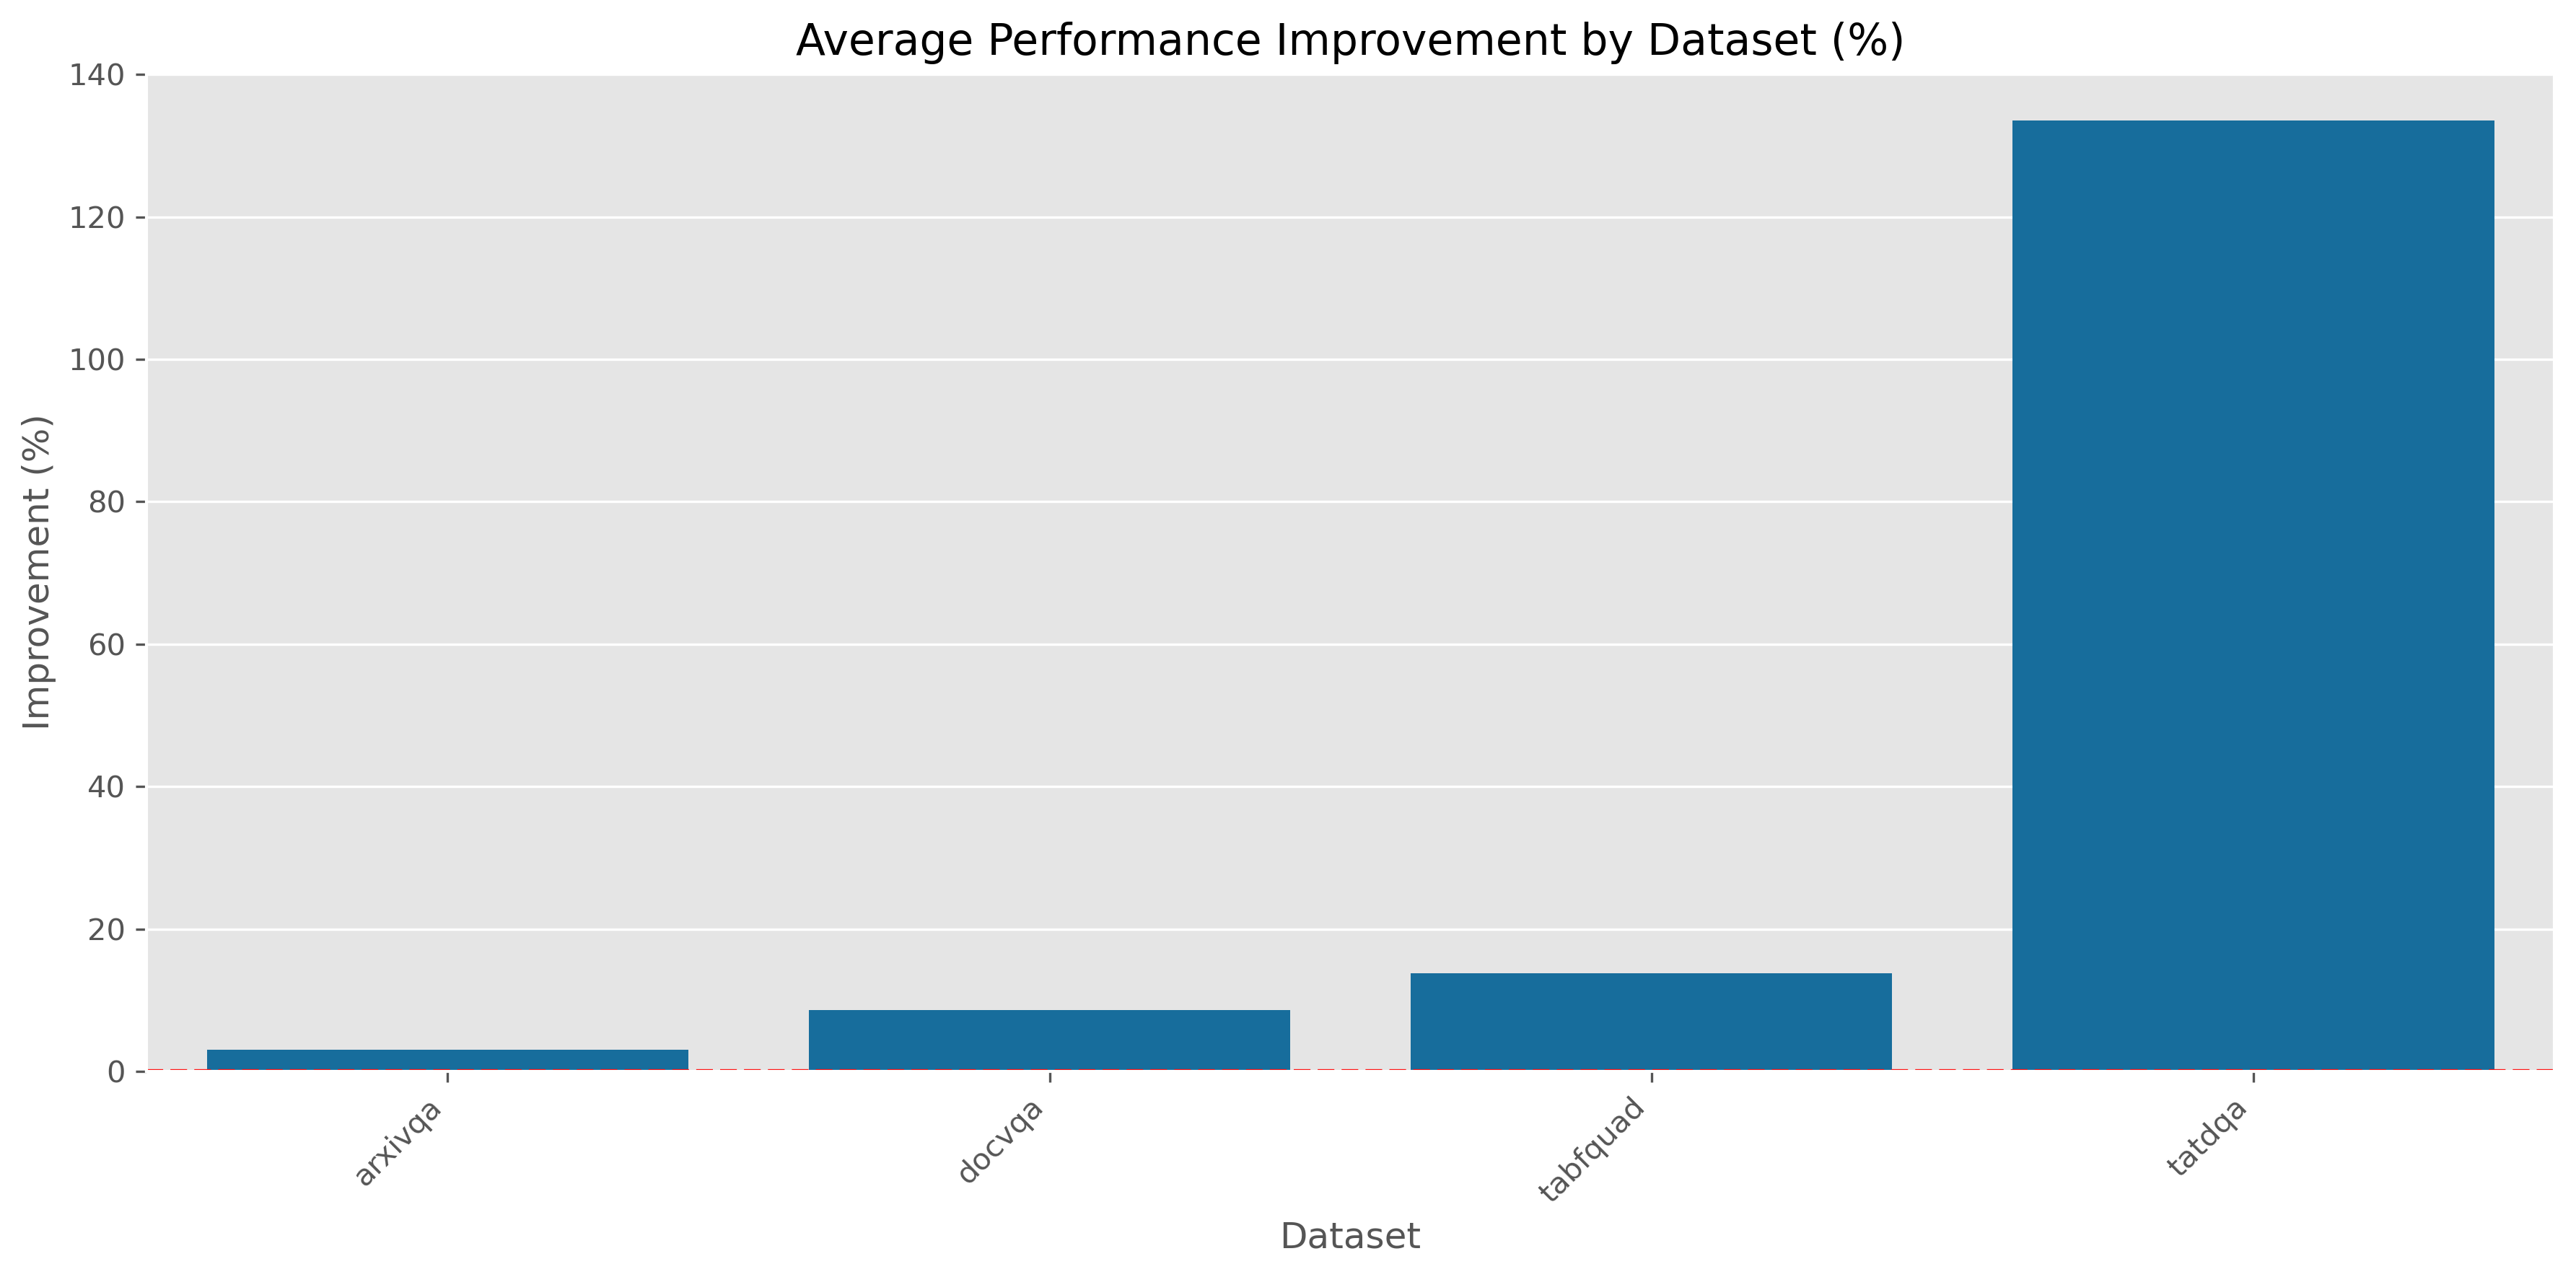

In [50]:
# Calculate average improvement by dataset
dataset_improvement = comparison_df.groupby('Dataset')['Improvement (%)'].mean().reset_index().sort_values('Improvement (%)')

plt.figure(figsize=(12, 6), dpi=300)
sns.barplot(data=dataset_improvement, x='Dataset', y='Improvement (%)')
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Average Performance Improvement by Dataset (%)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Detailed Comparison for Specific Models

In [51]:
# Function to plot metric comparison for a specific model and dataset
def plot_model_comparison(base_model, dataset, metric):
    filtered_df = comparison_df[(comparison_df['Base Model'] == base_model) & 
                               (comparison_df['Dataset'] == dataset) & 
                               (comparison_df['Metric'] == metric)]
    
    if filtered_df.empty:
        print(f"No data found for {base_model} on {dataset} with metric {metric}")
        return
    
    plt.figure(figsize=(10, 6), dpi=300)
    
    # Plot normal values
    plt.plot(filtered_df['k'], filtered_df['Normal Value'], marker='o', label='Normal')
    
    # Plot each segmentation pattern if there are multiple
    for pattern in filtered_df['Segmentation Pattern'].unique():
        pattern_df = filtered_df[filtered_df['Segmentation Pattern'] == pattern]
        label = f"Segmented ({pattern})" if pattern else "Segmented"
        plt.plot(pattern_df['k'], pattern_df['Segmented Value'], marker='s', label=label)
    
    plt.title(f'{metric.upper()} at k: {base_model} on {dataset}')
    plt.xlabel('k value')
    plt.ylabel(f'{metric.upper()} value')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()


### blip_Salesforce_blip-vqa-base on arxivqa



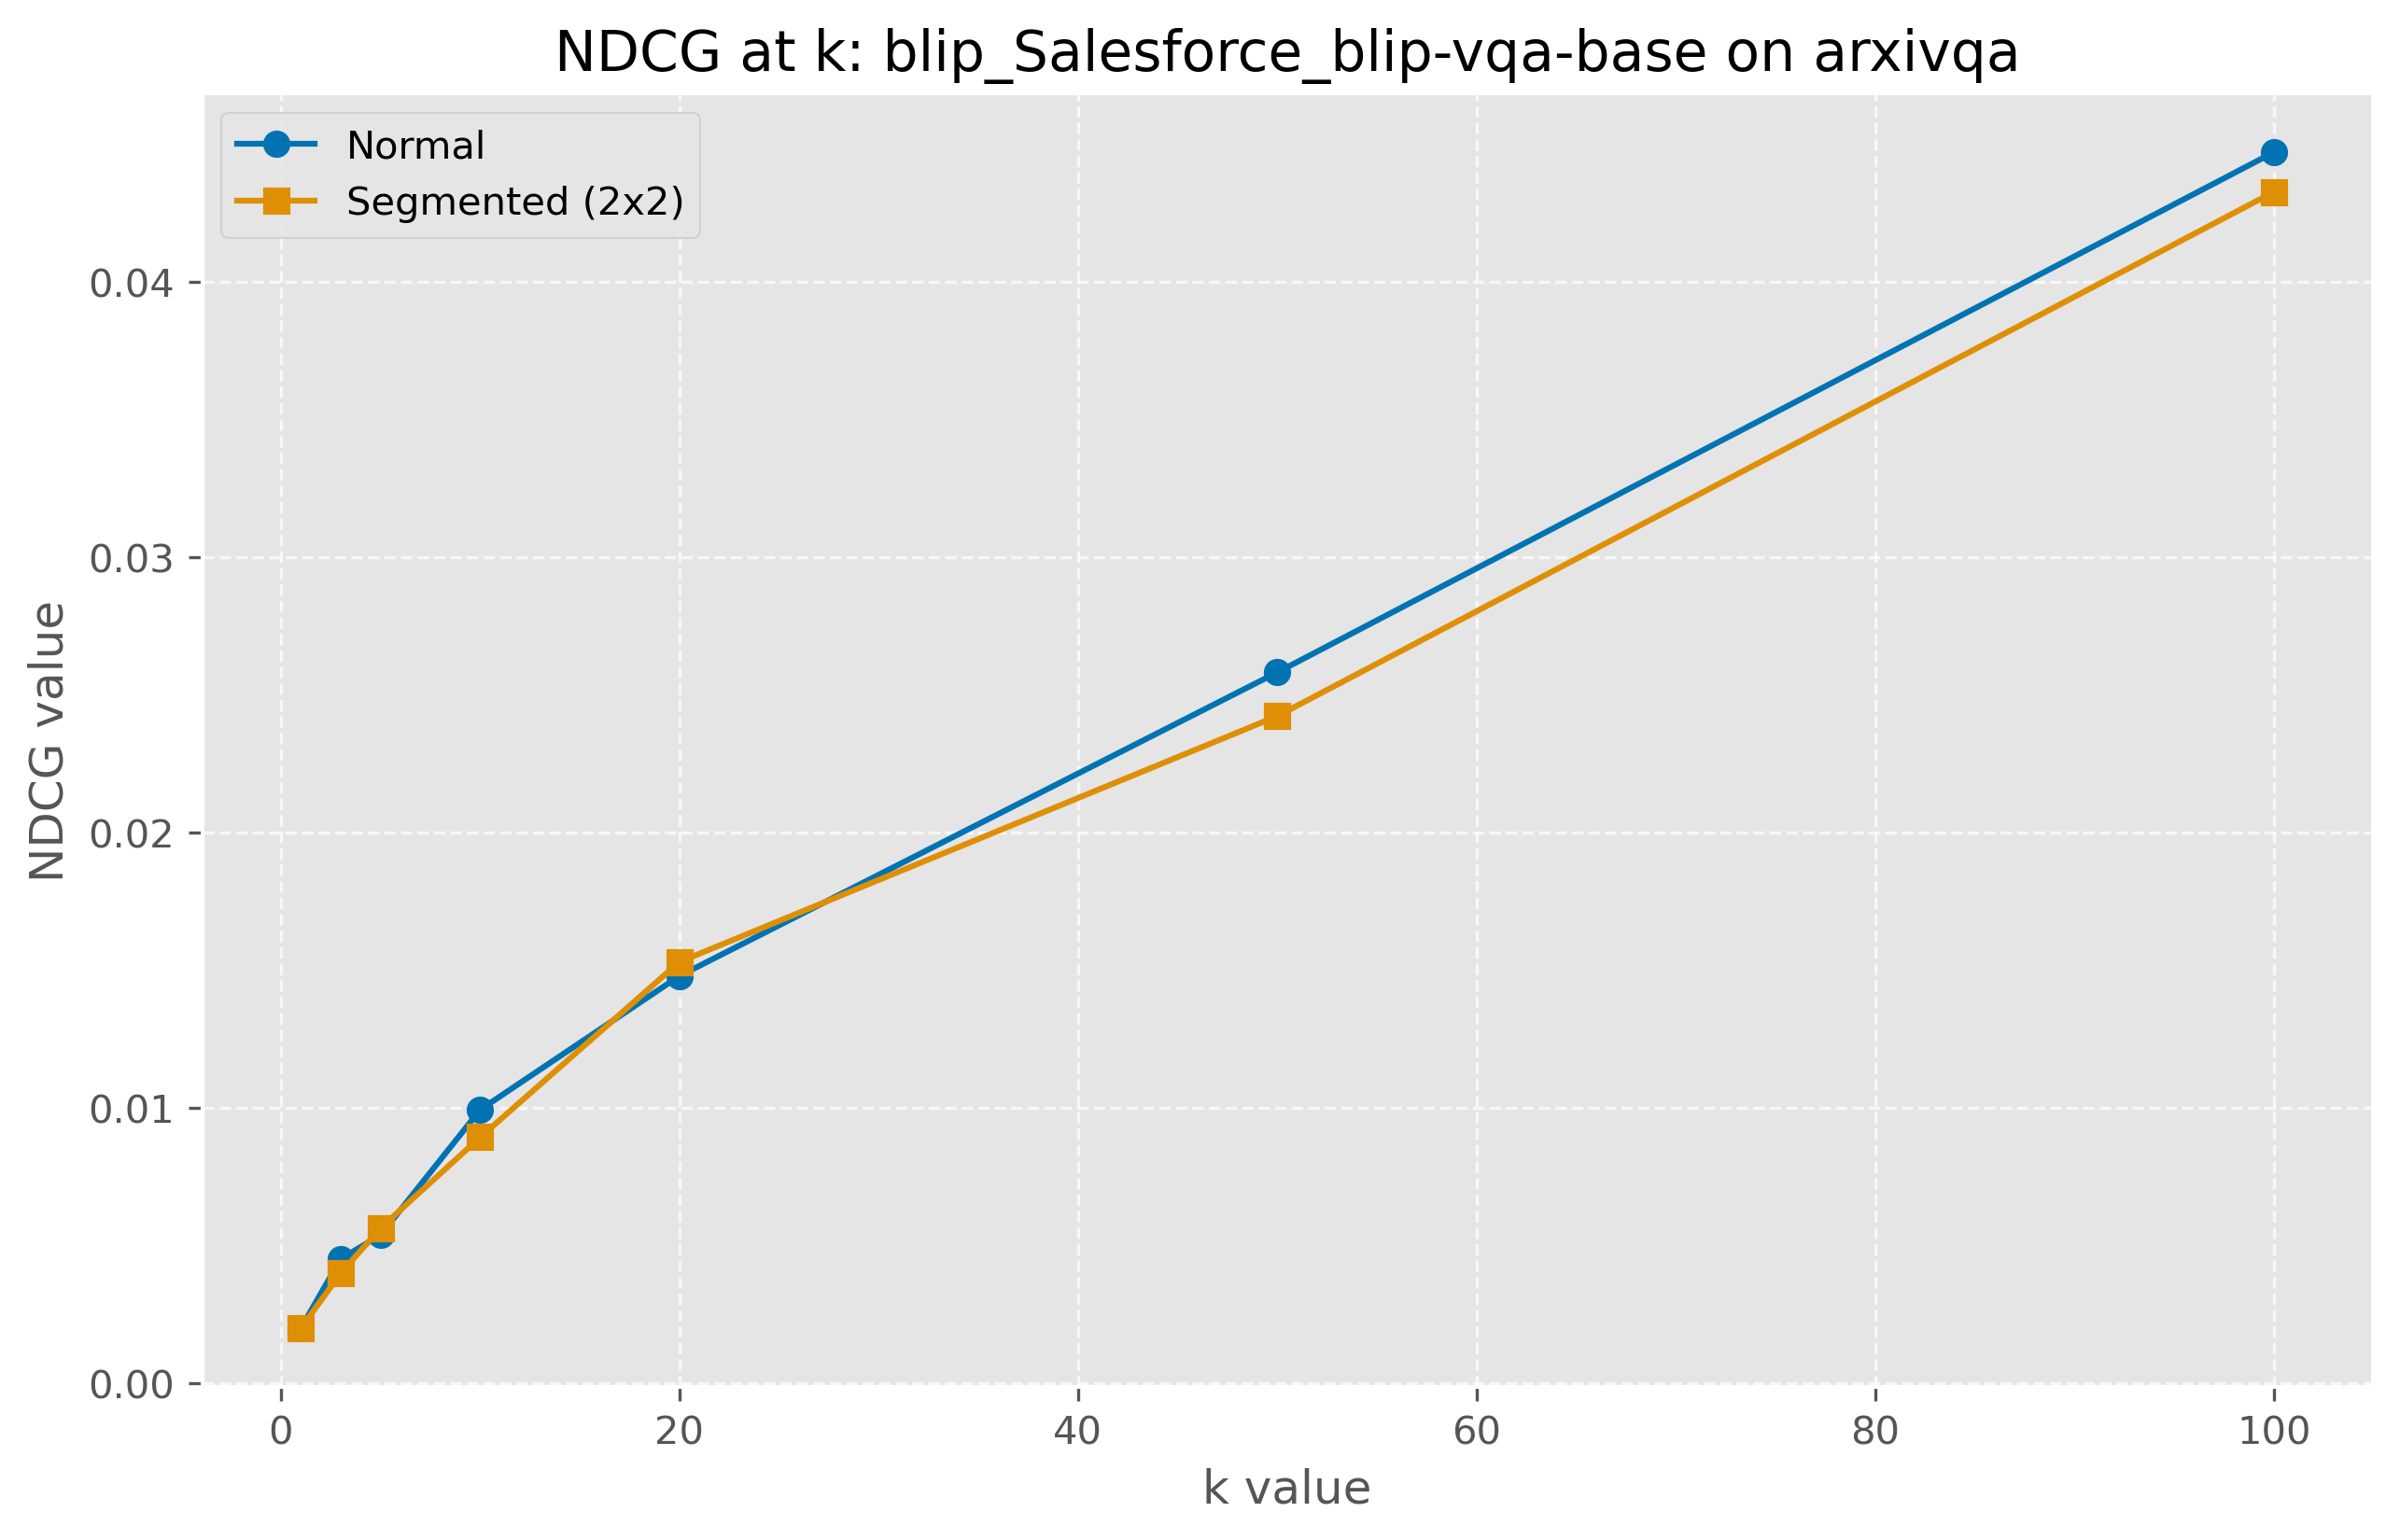

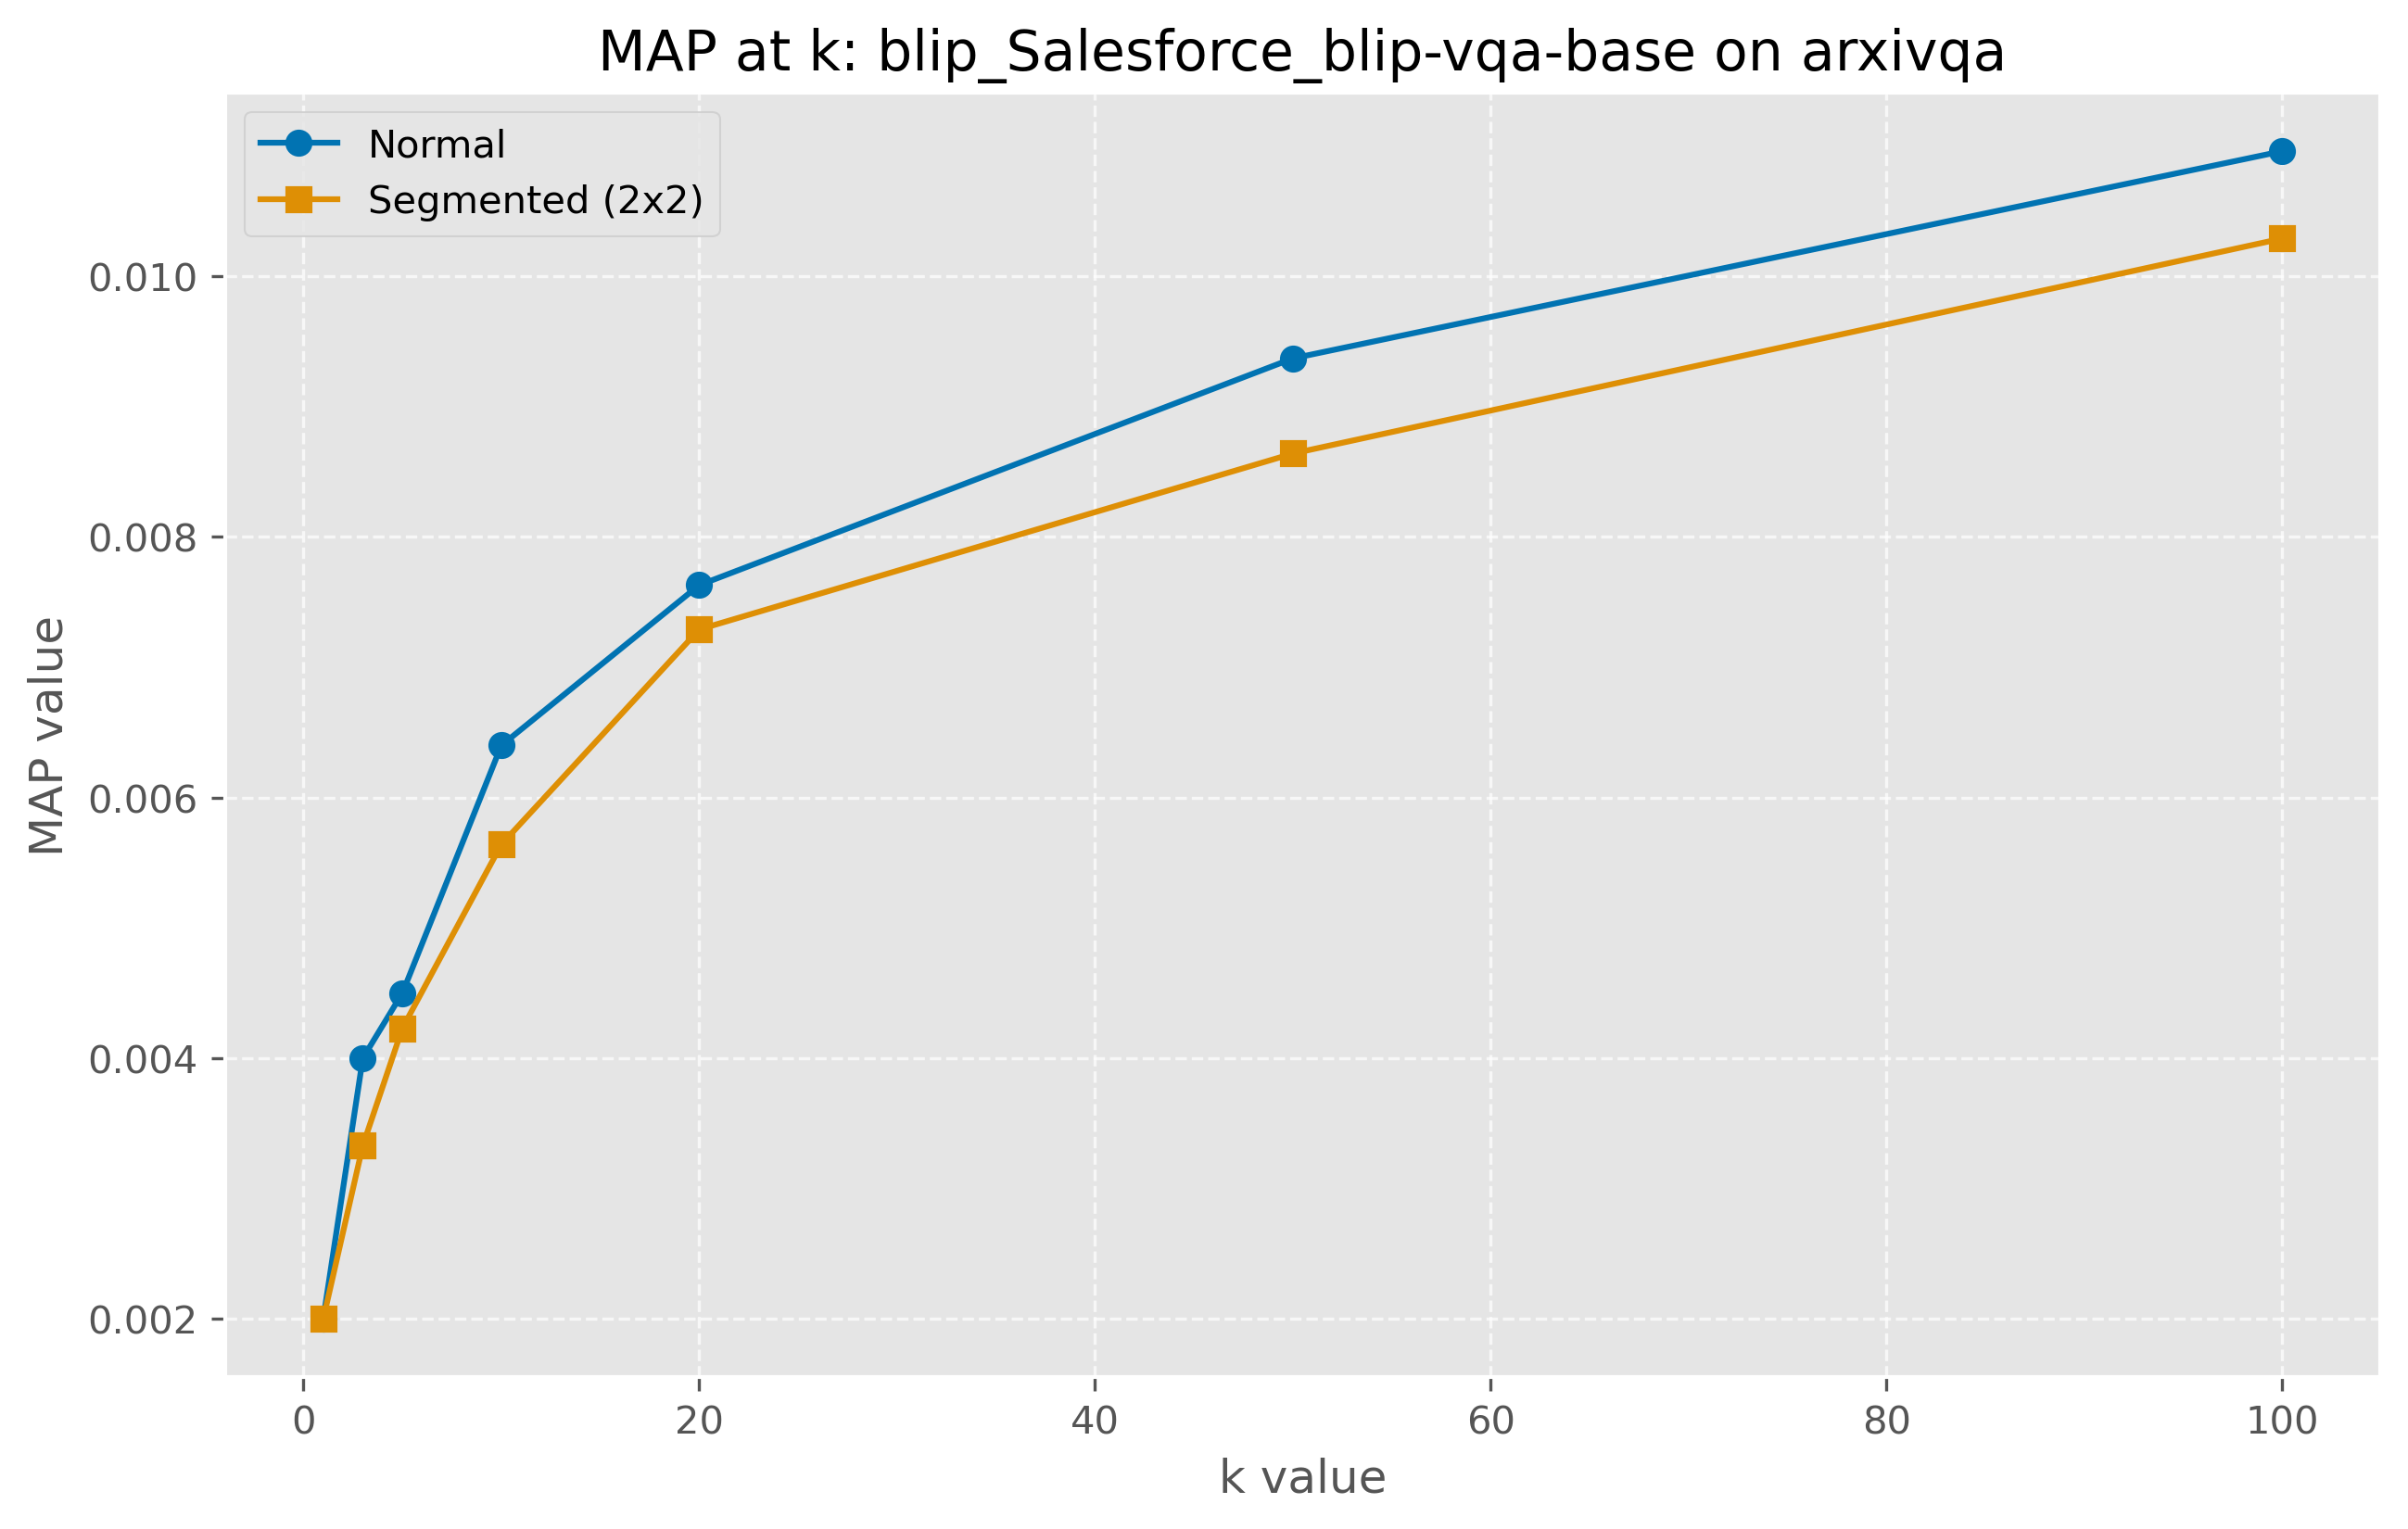

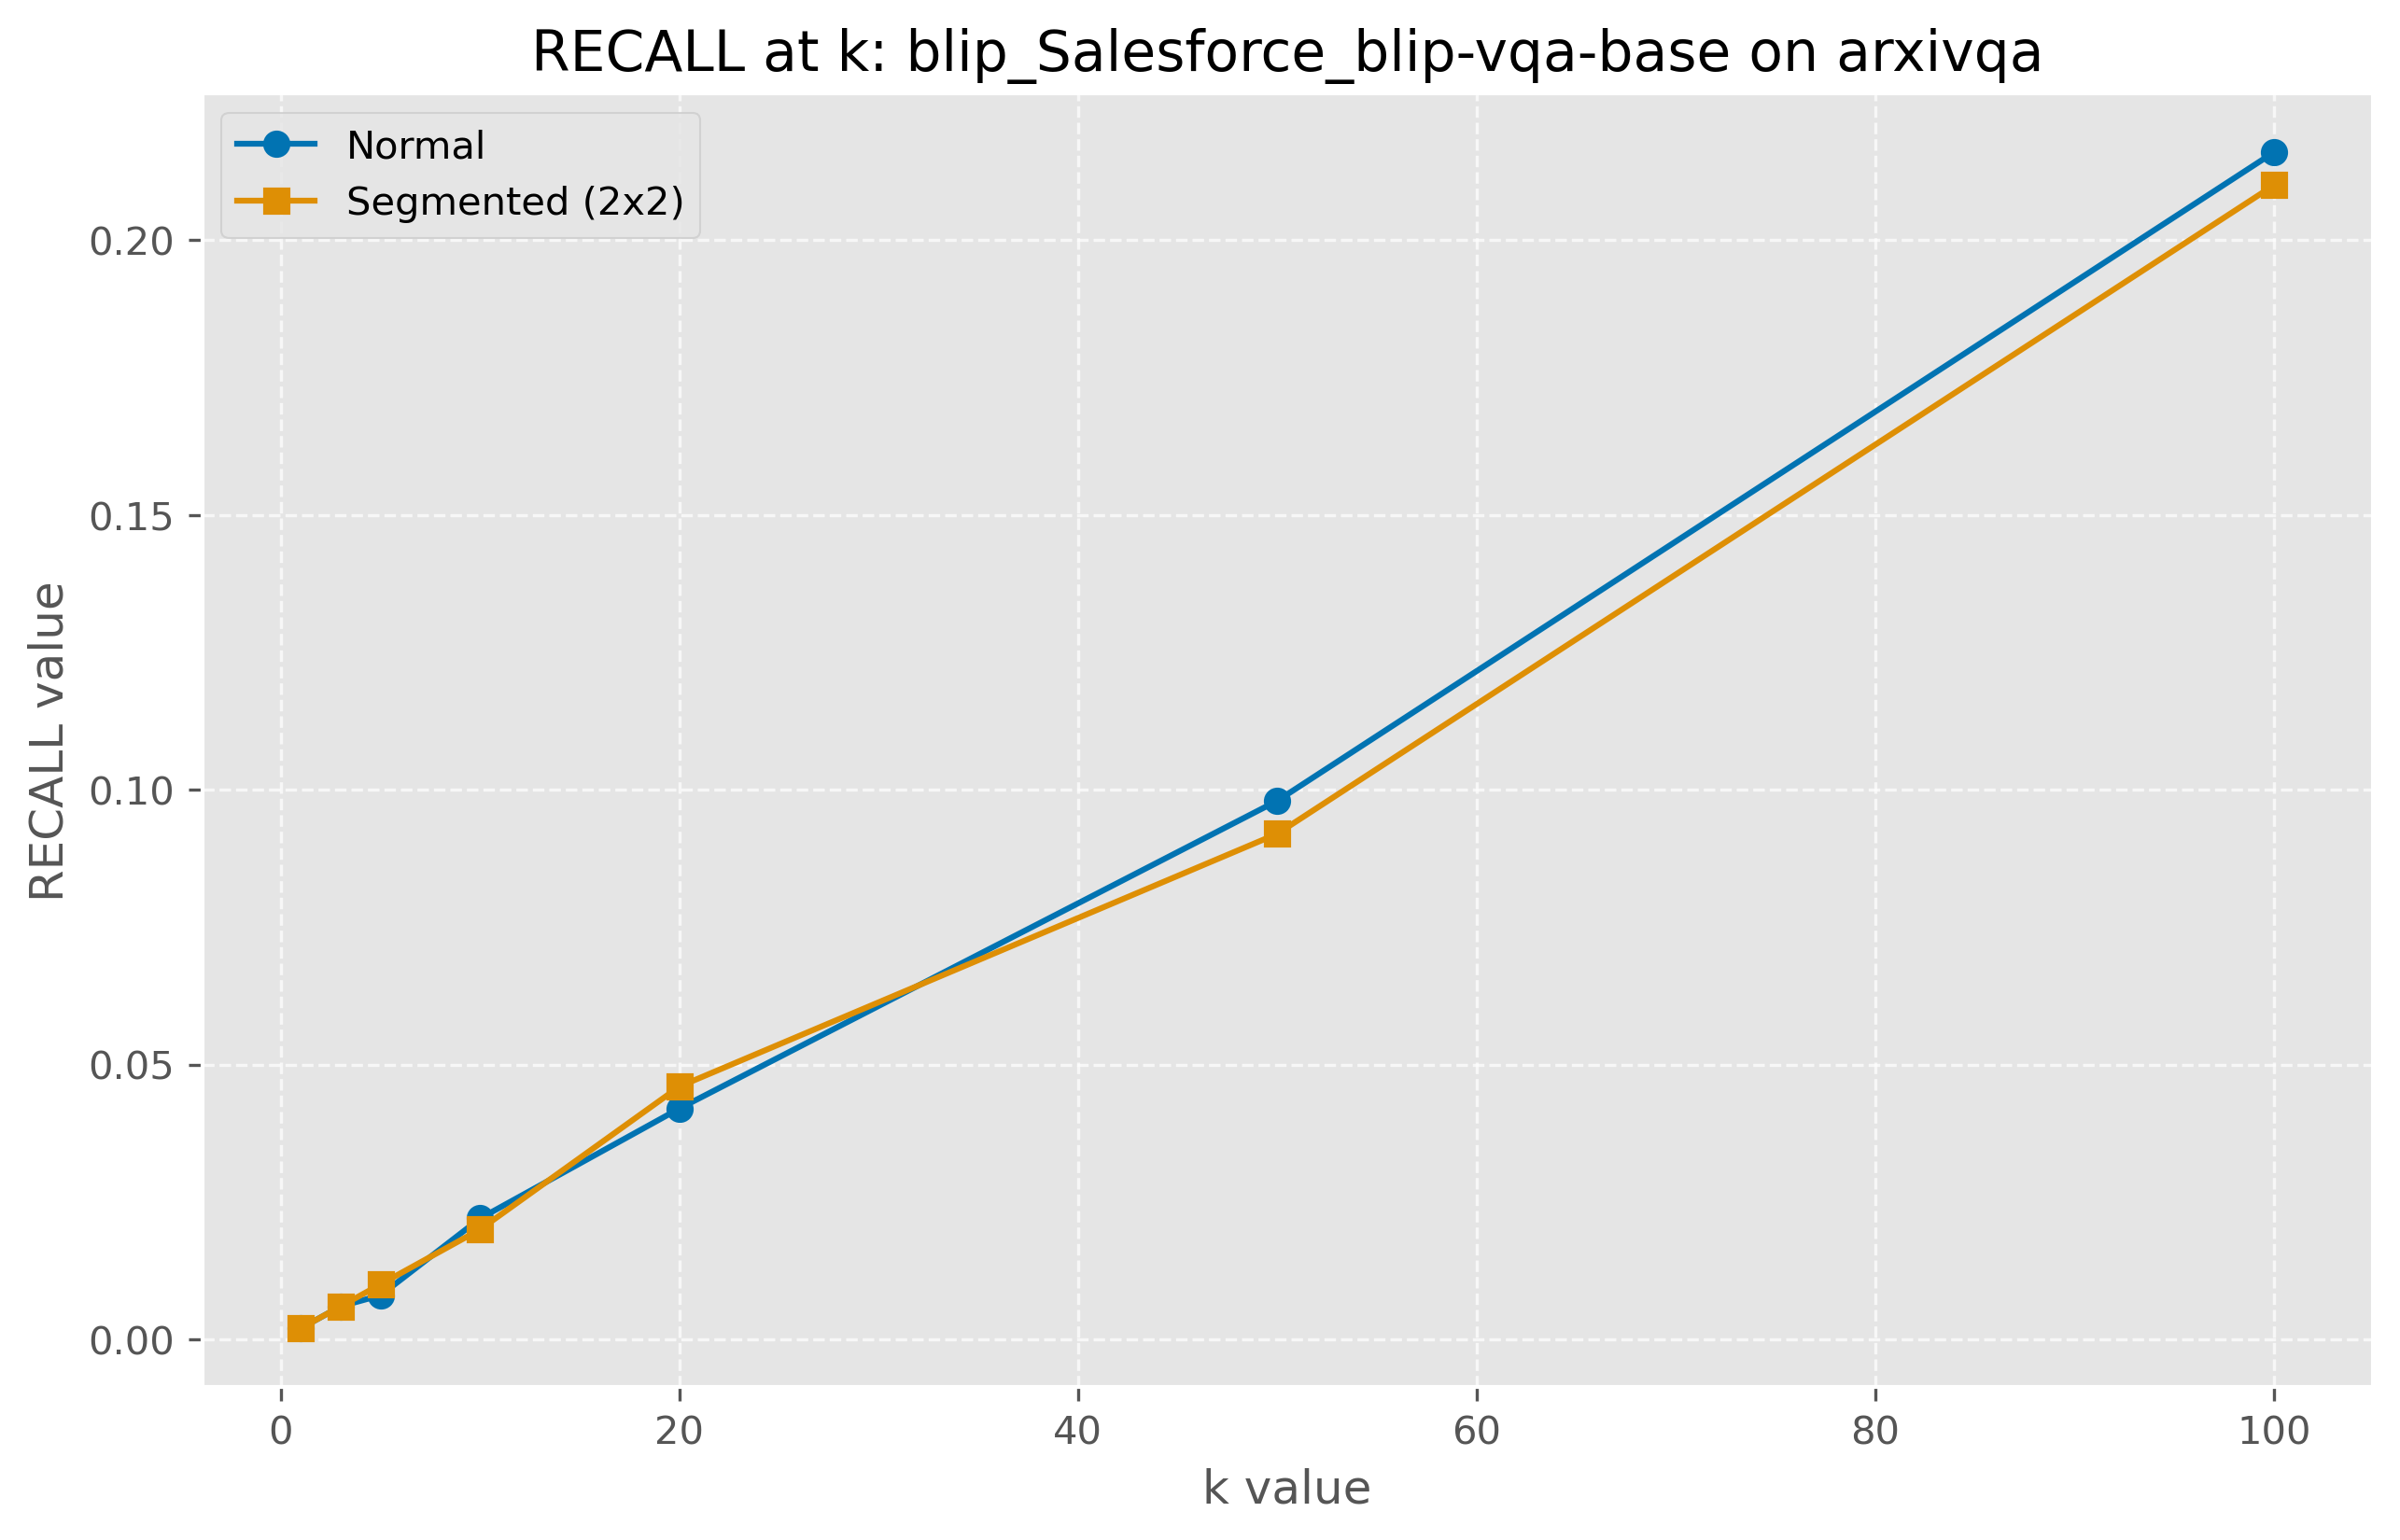

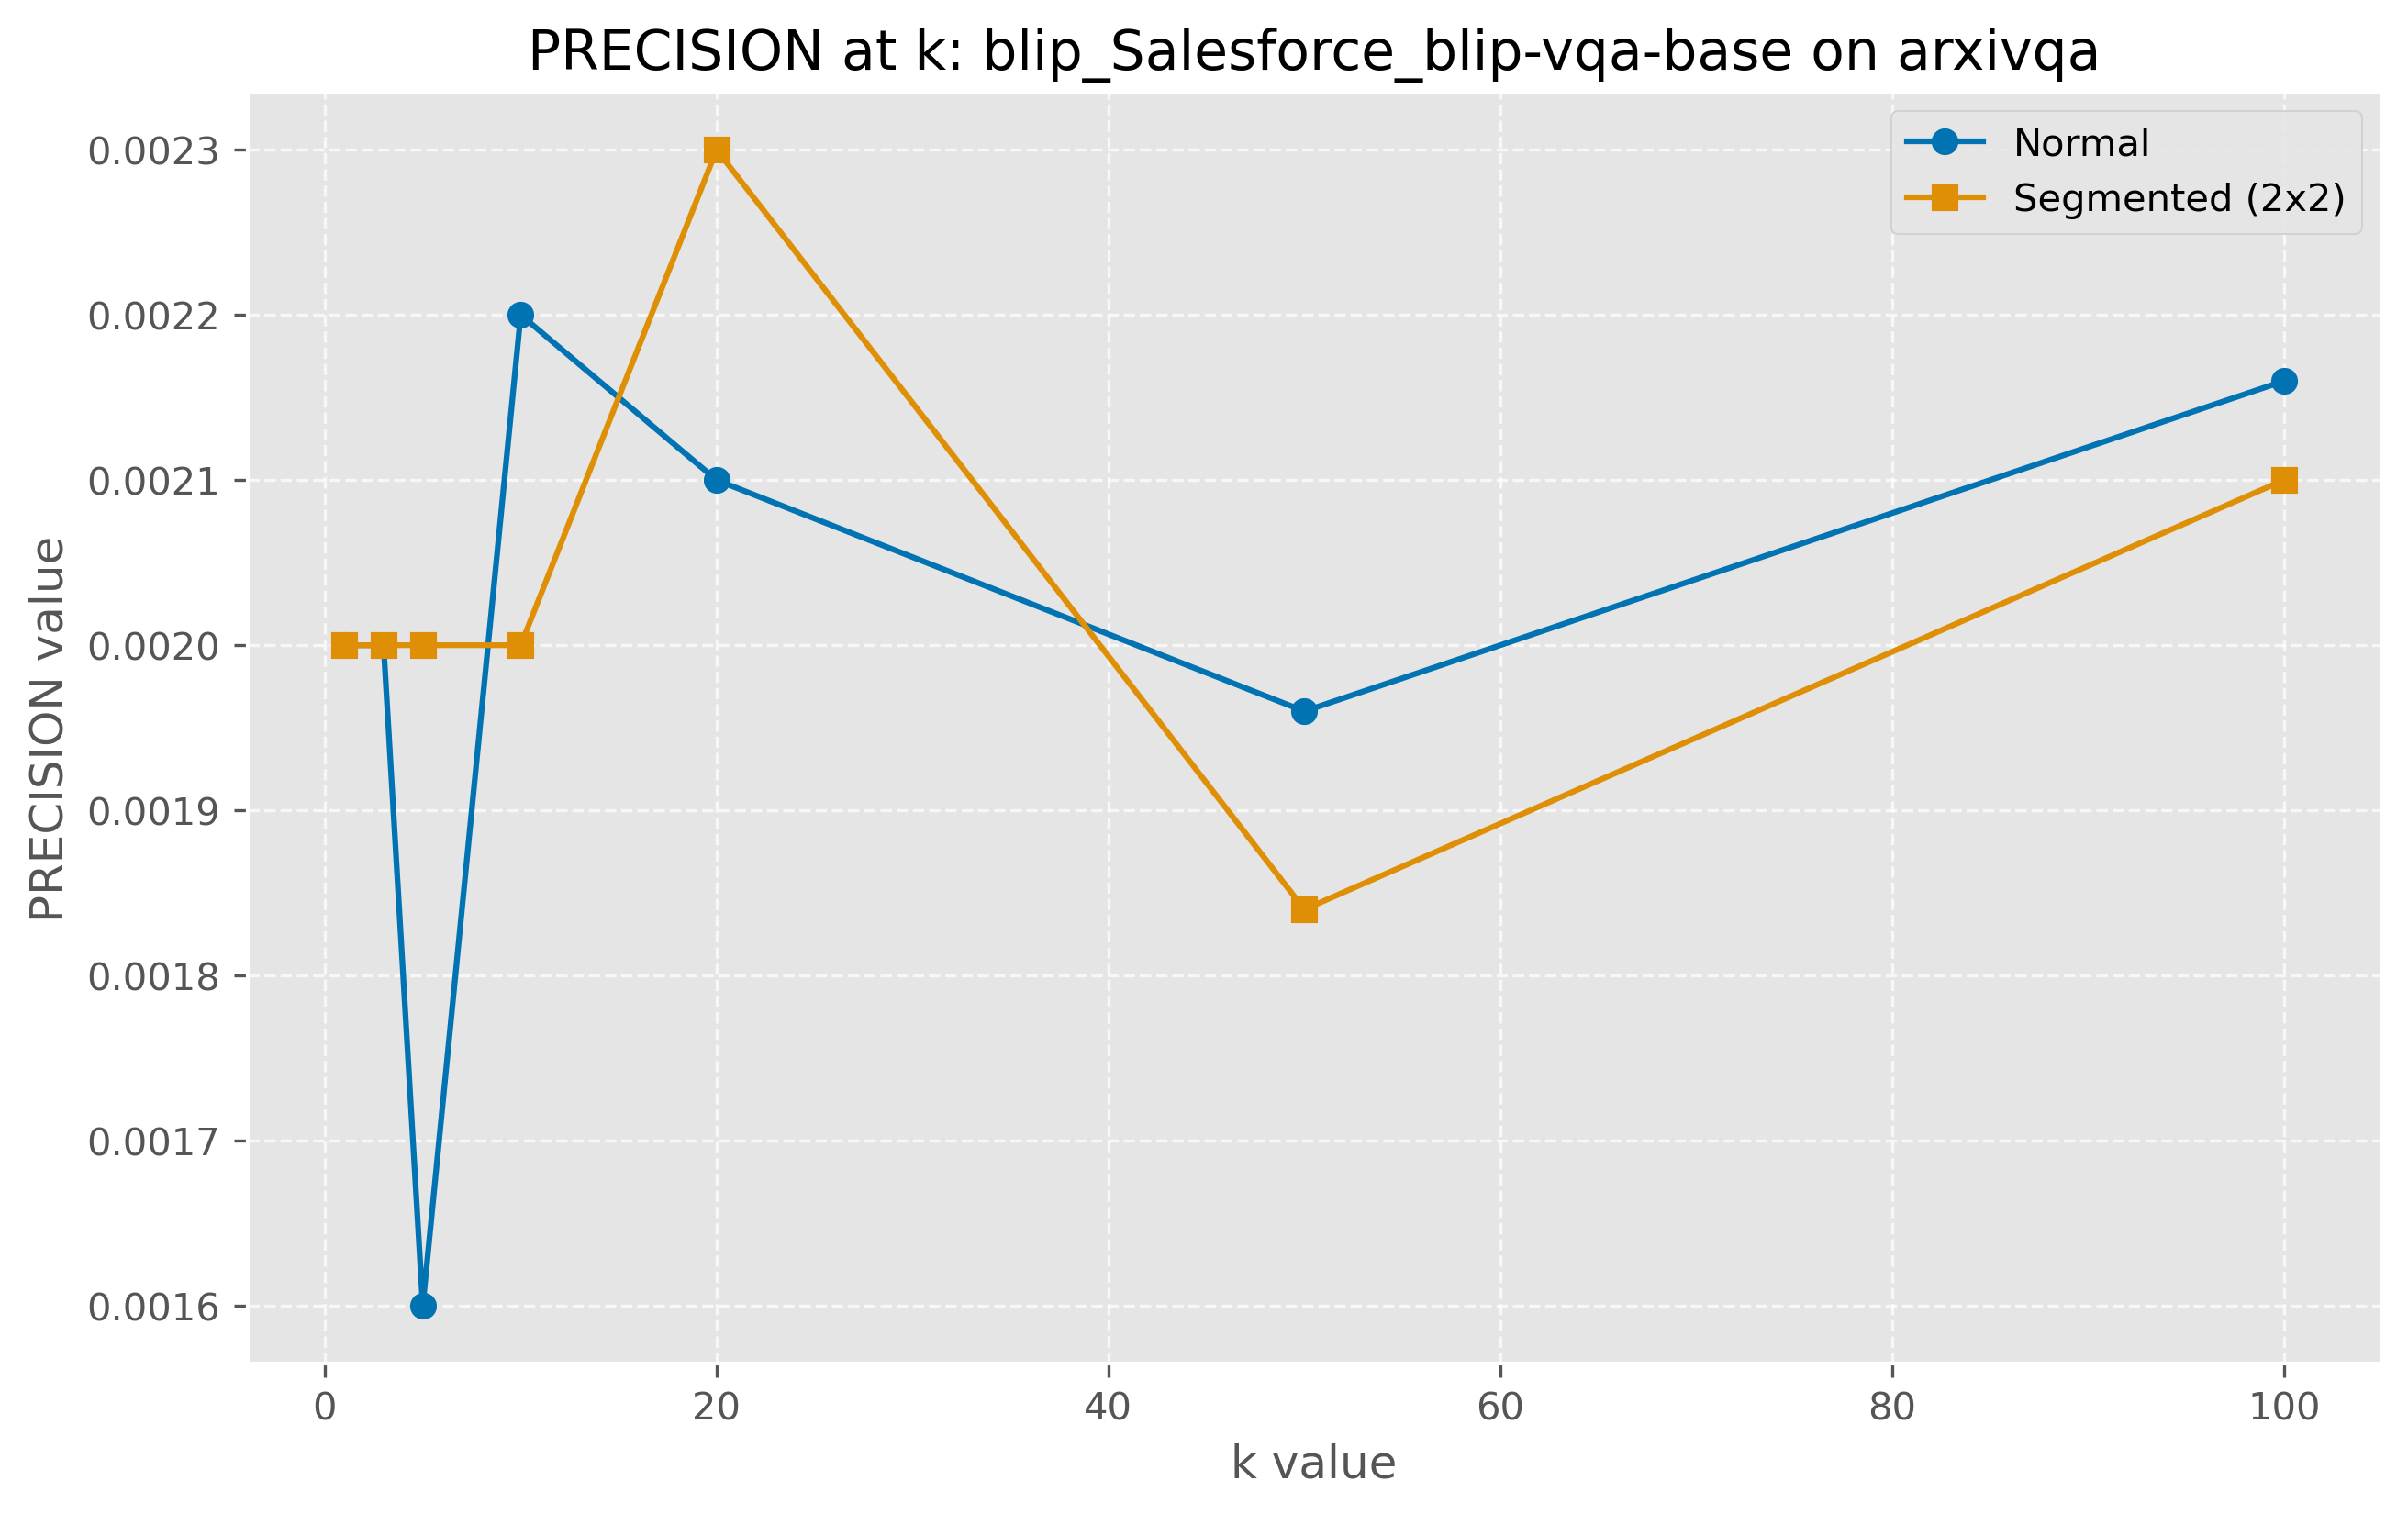


### blip_Salesforce_blip-vqa-base on docvqa



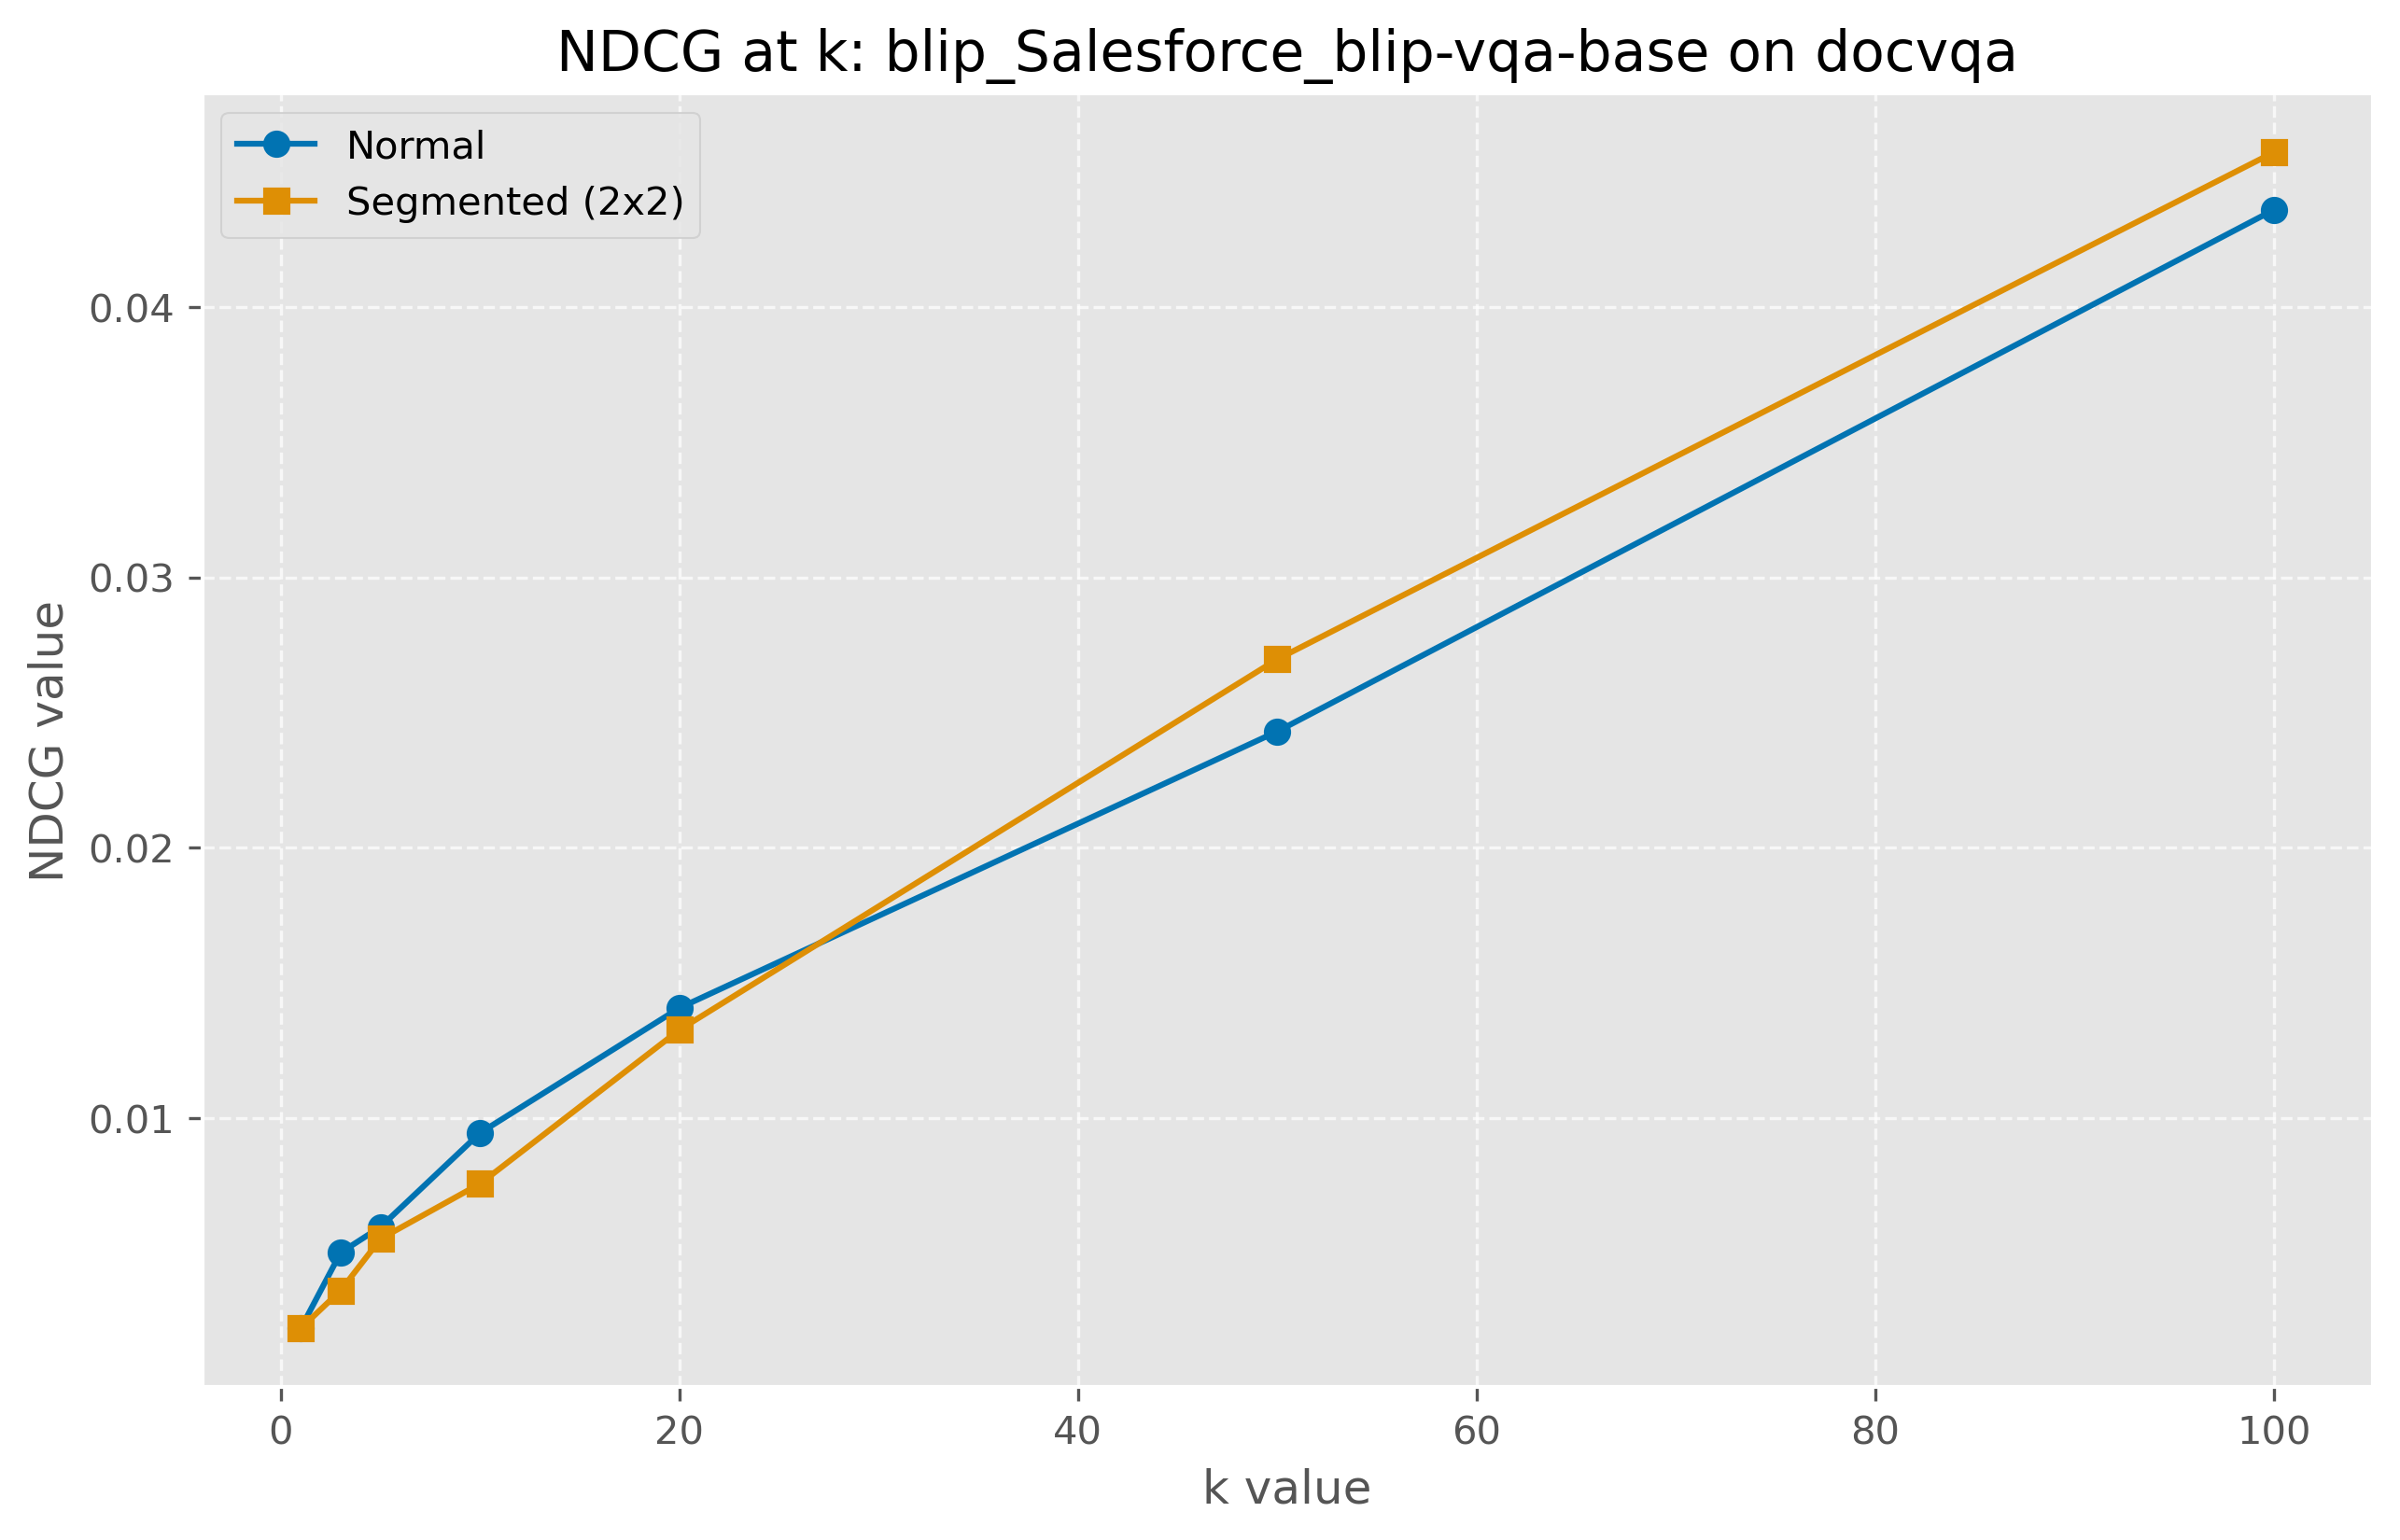

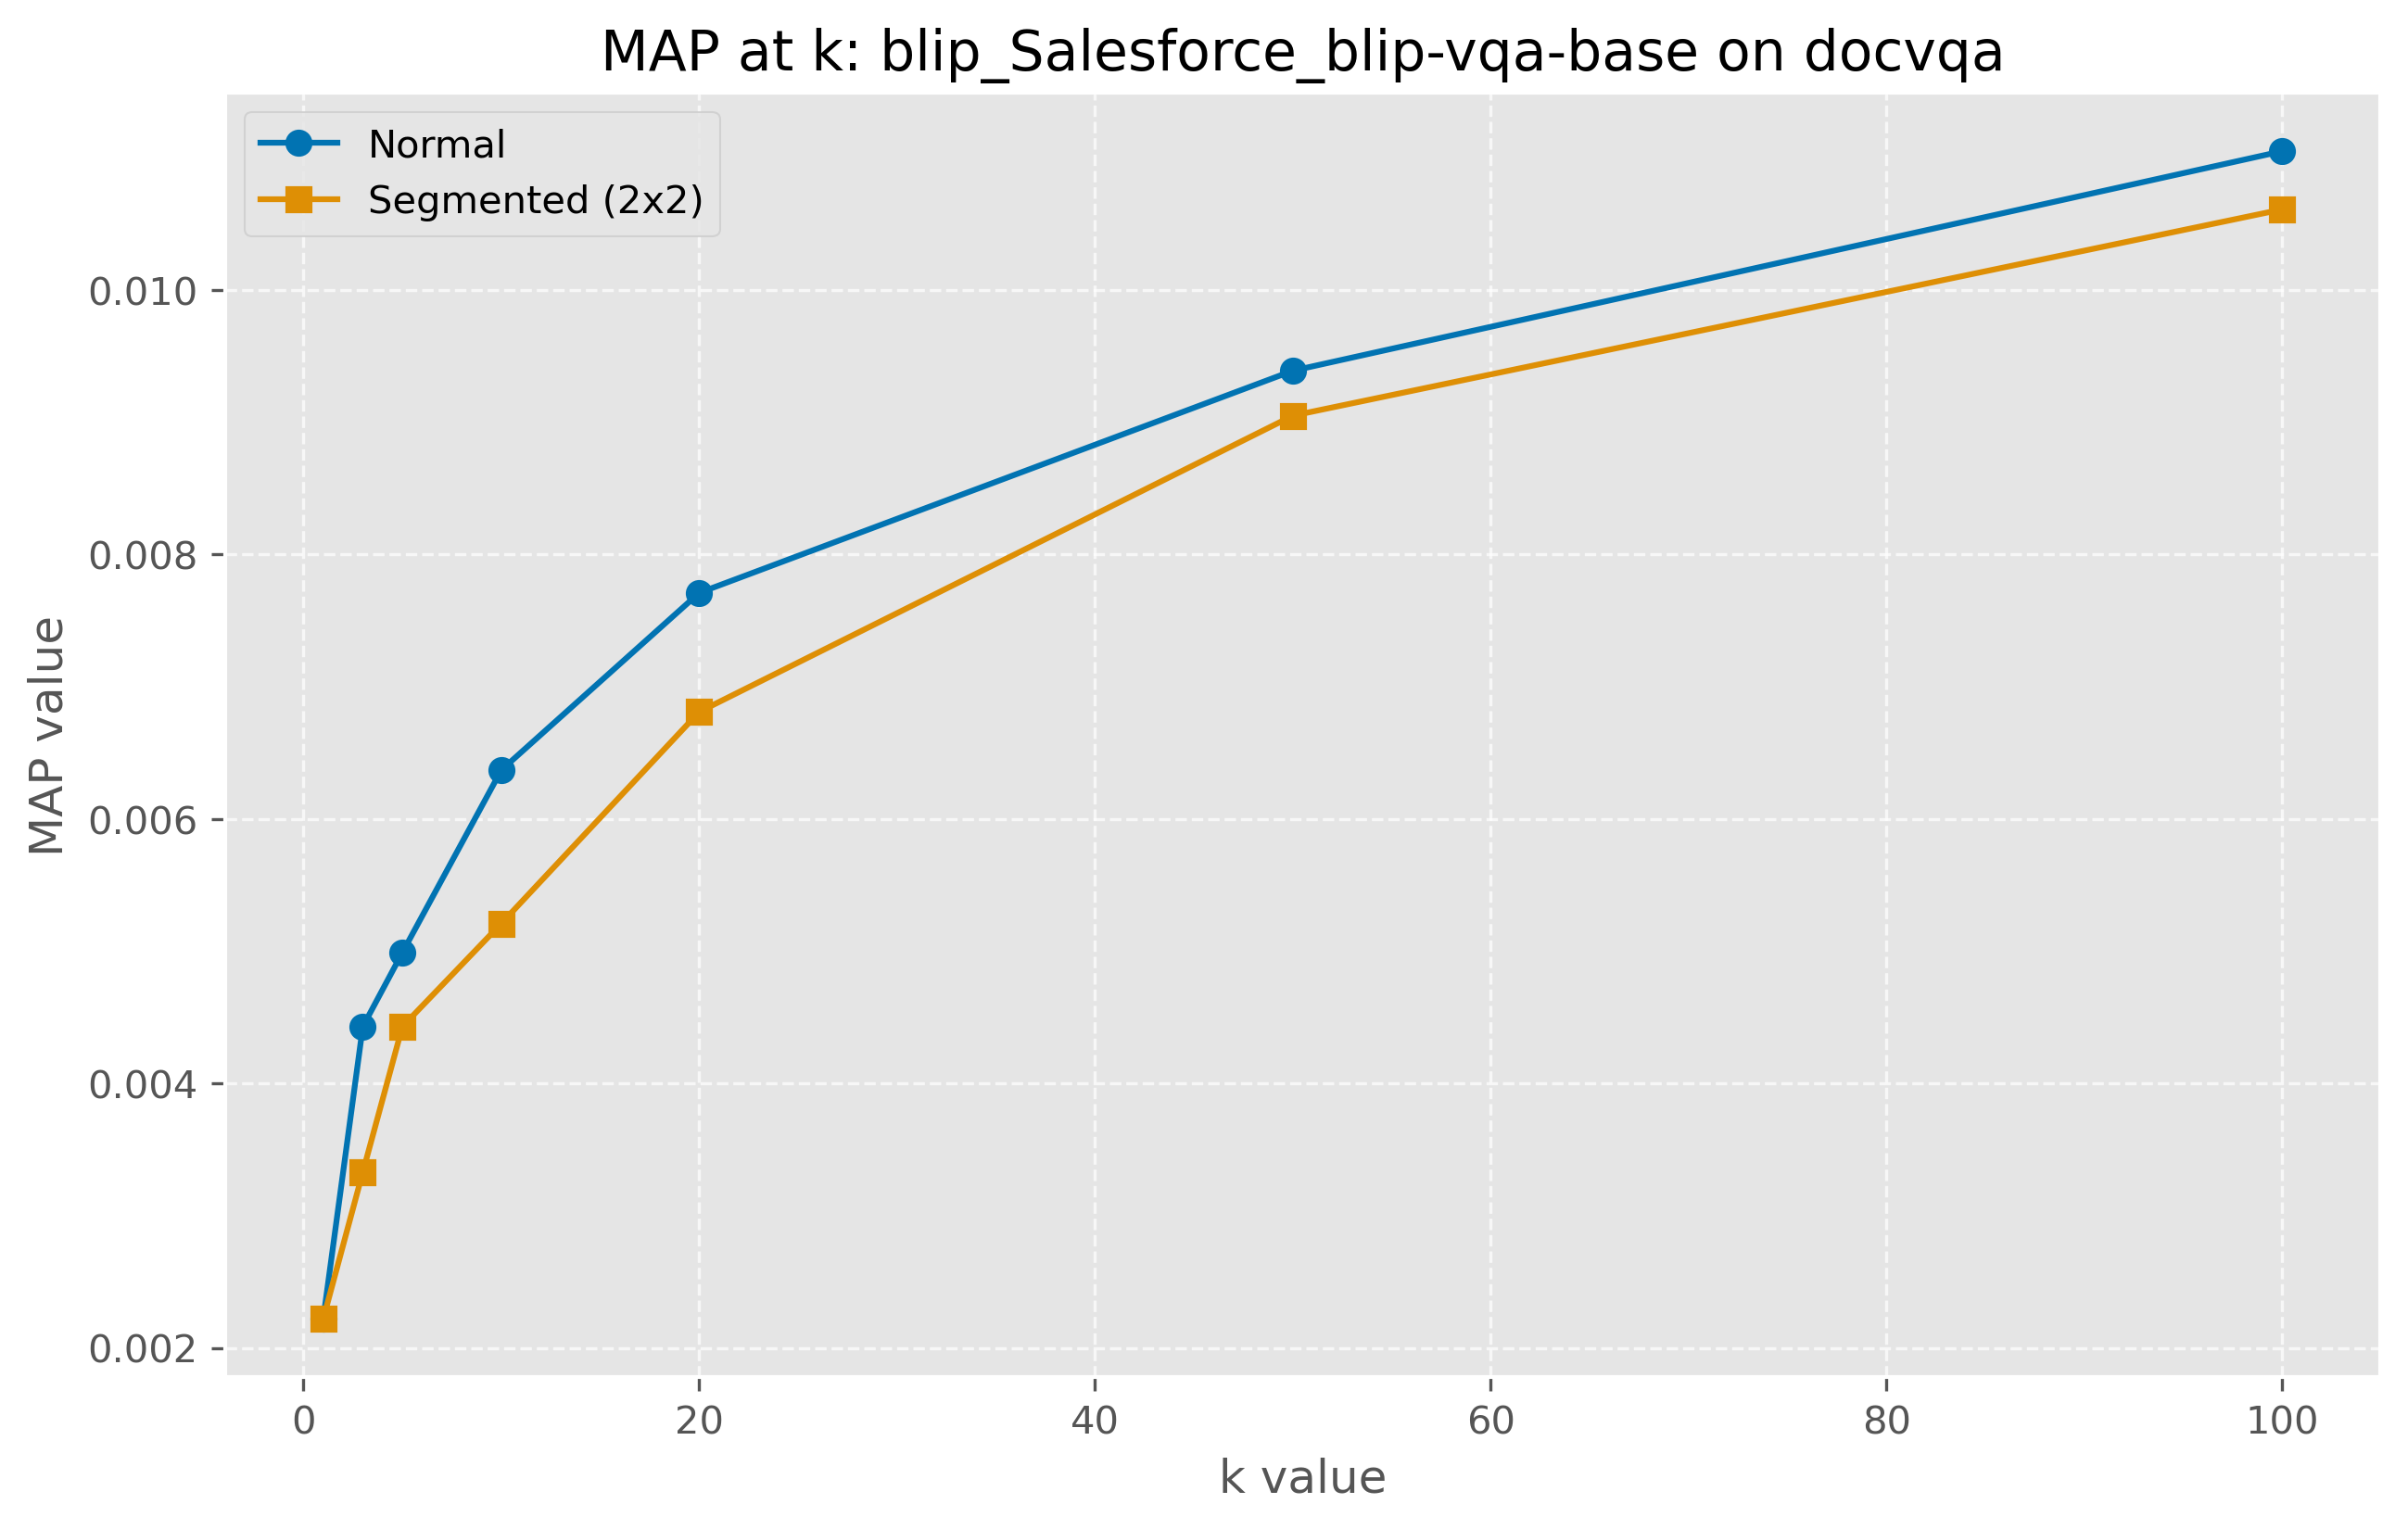

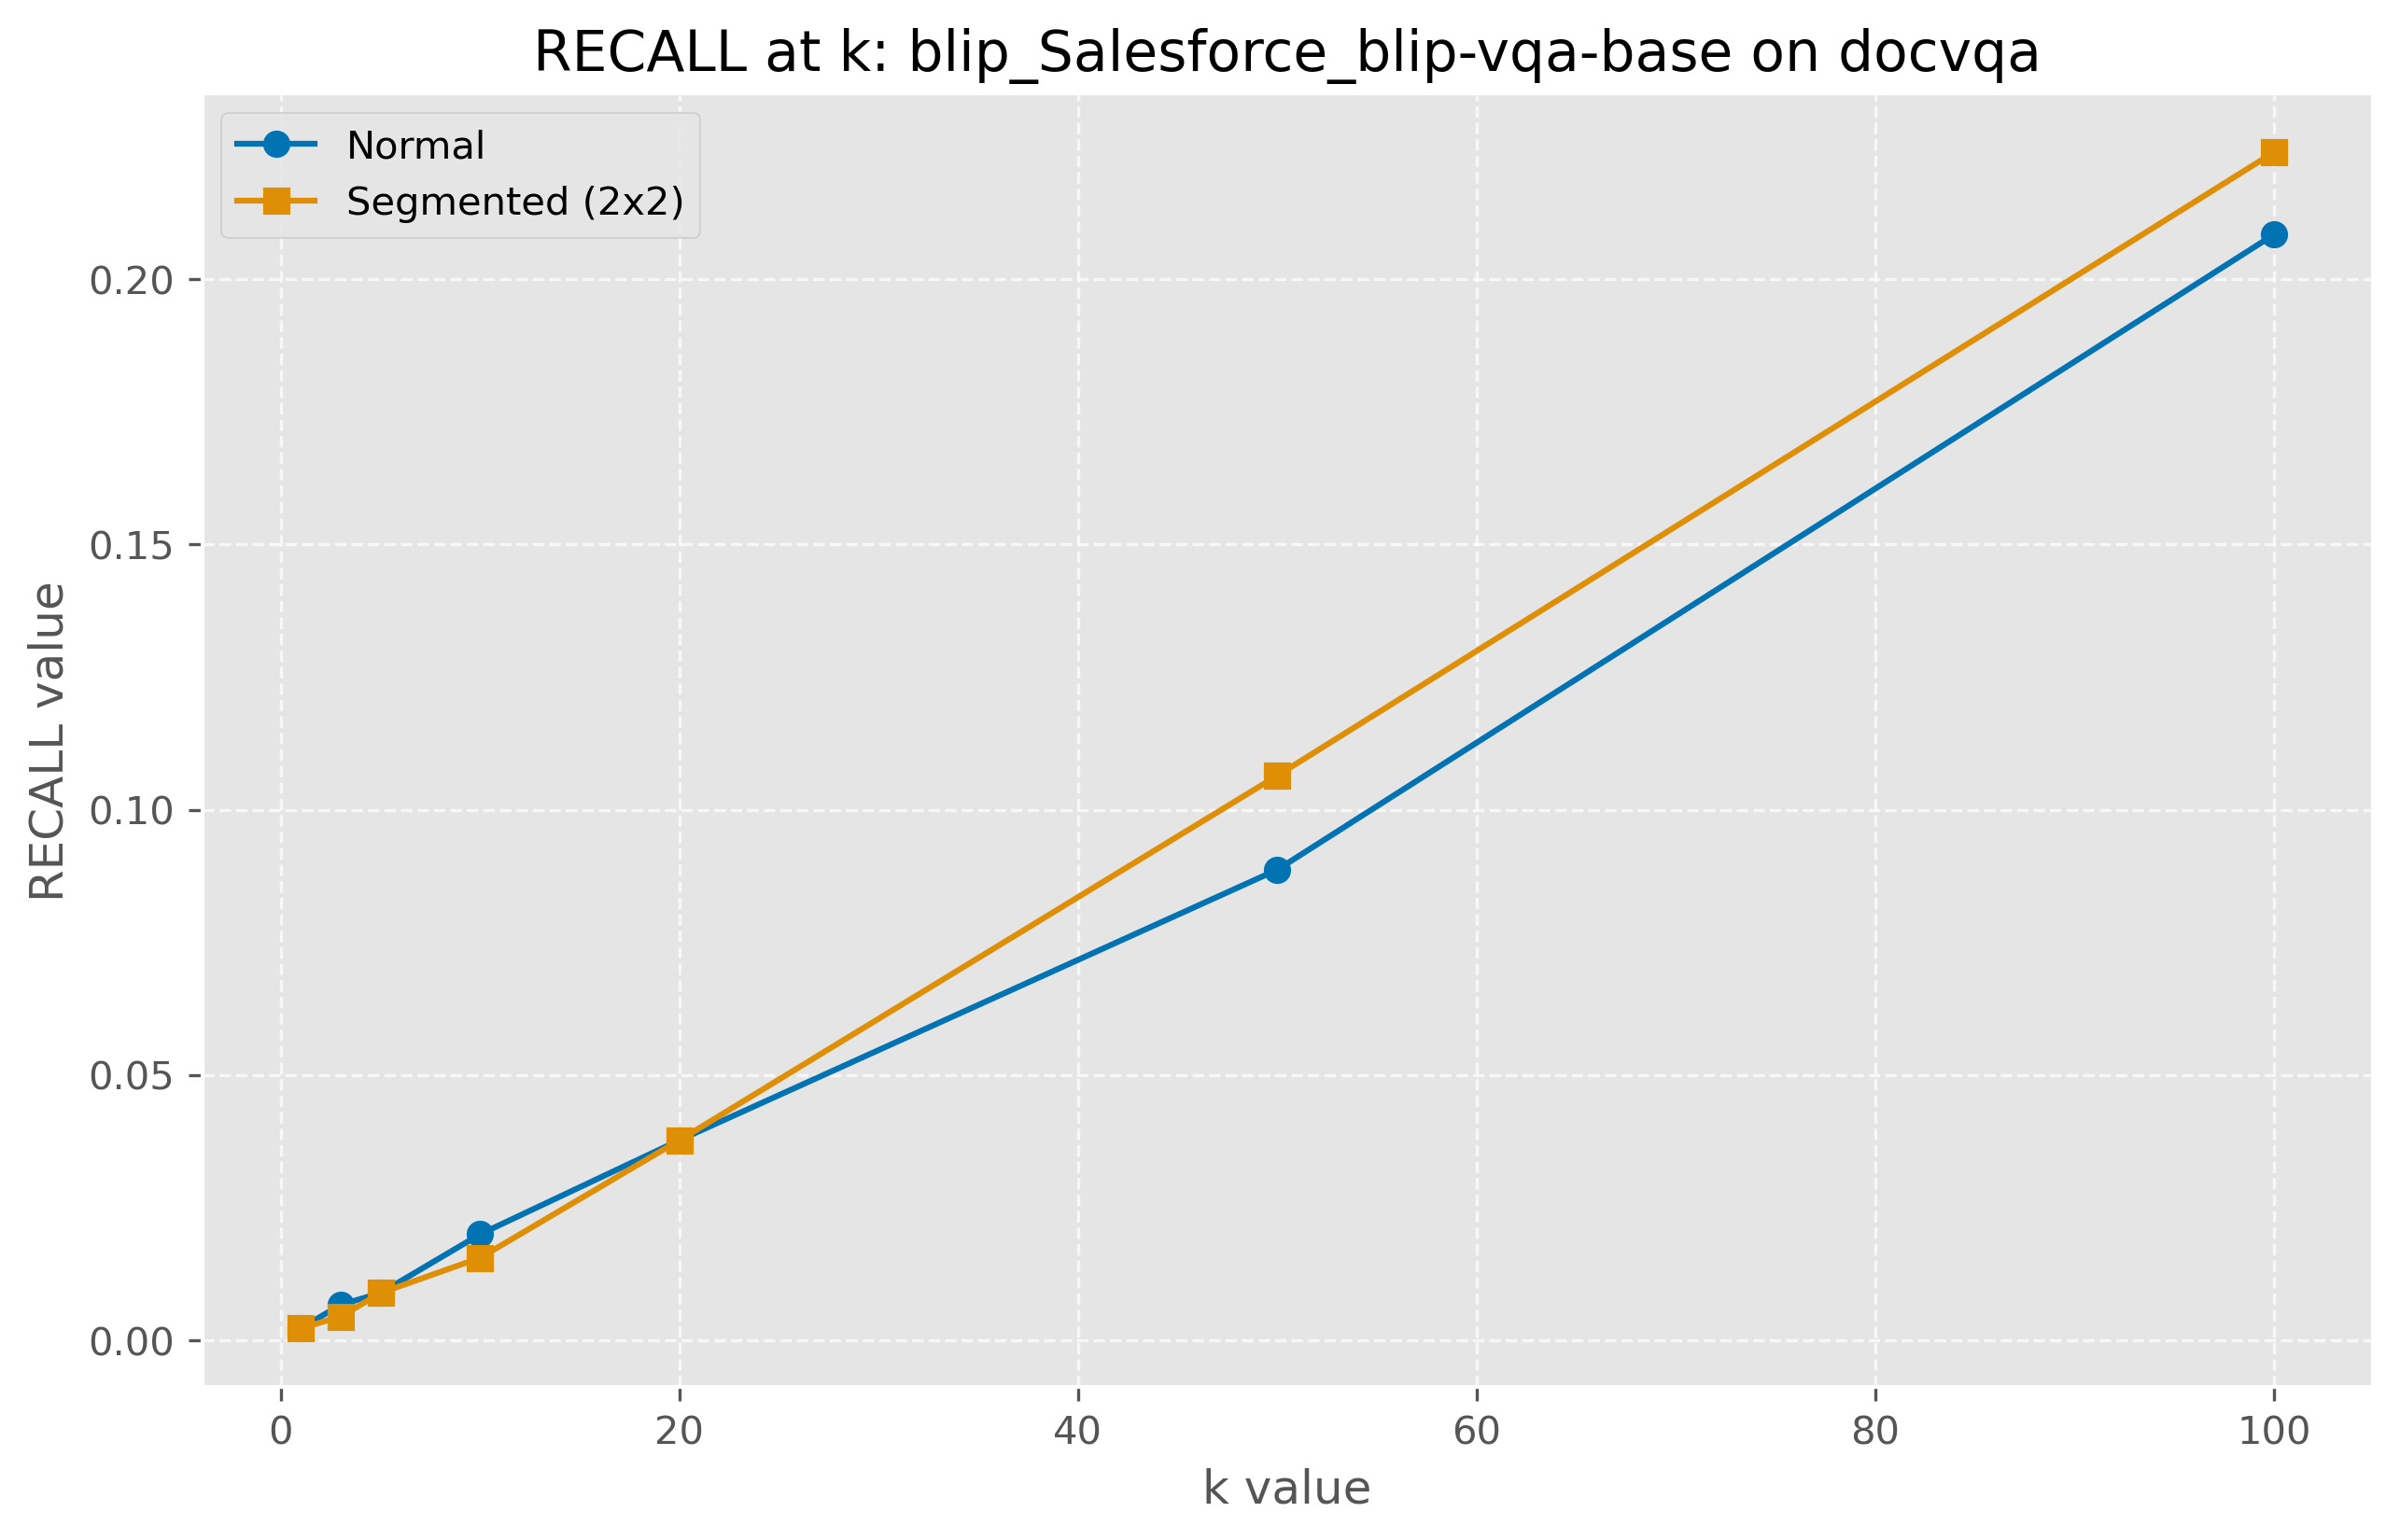

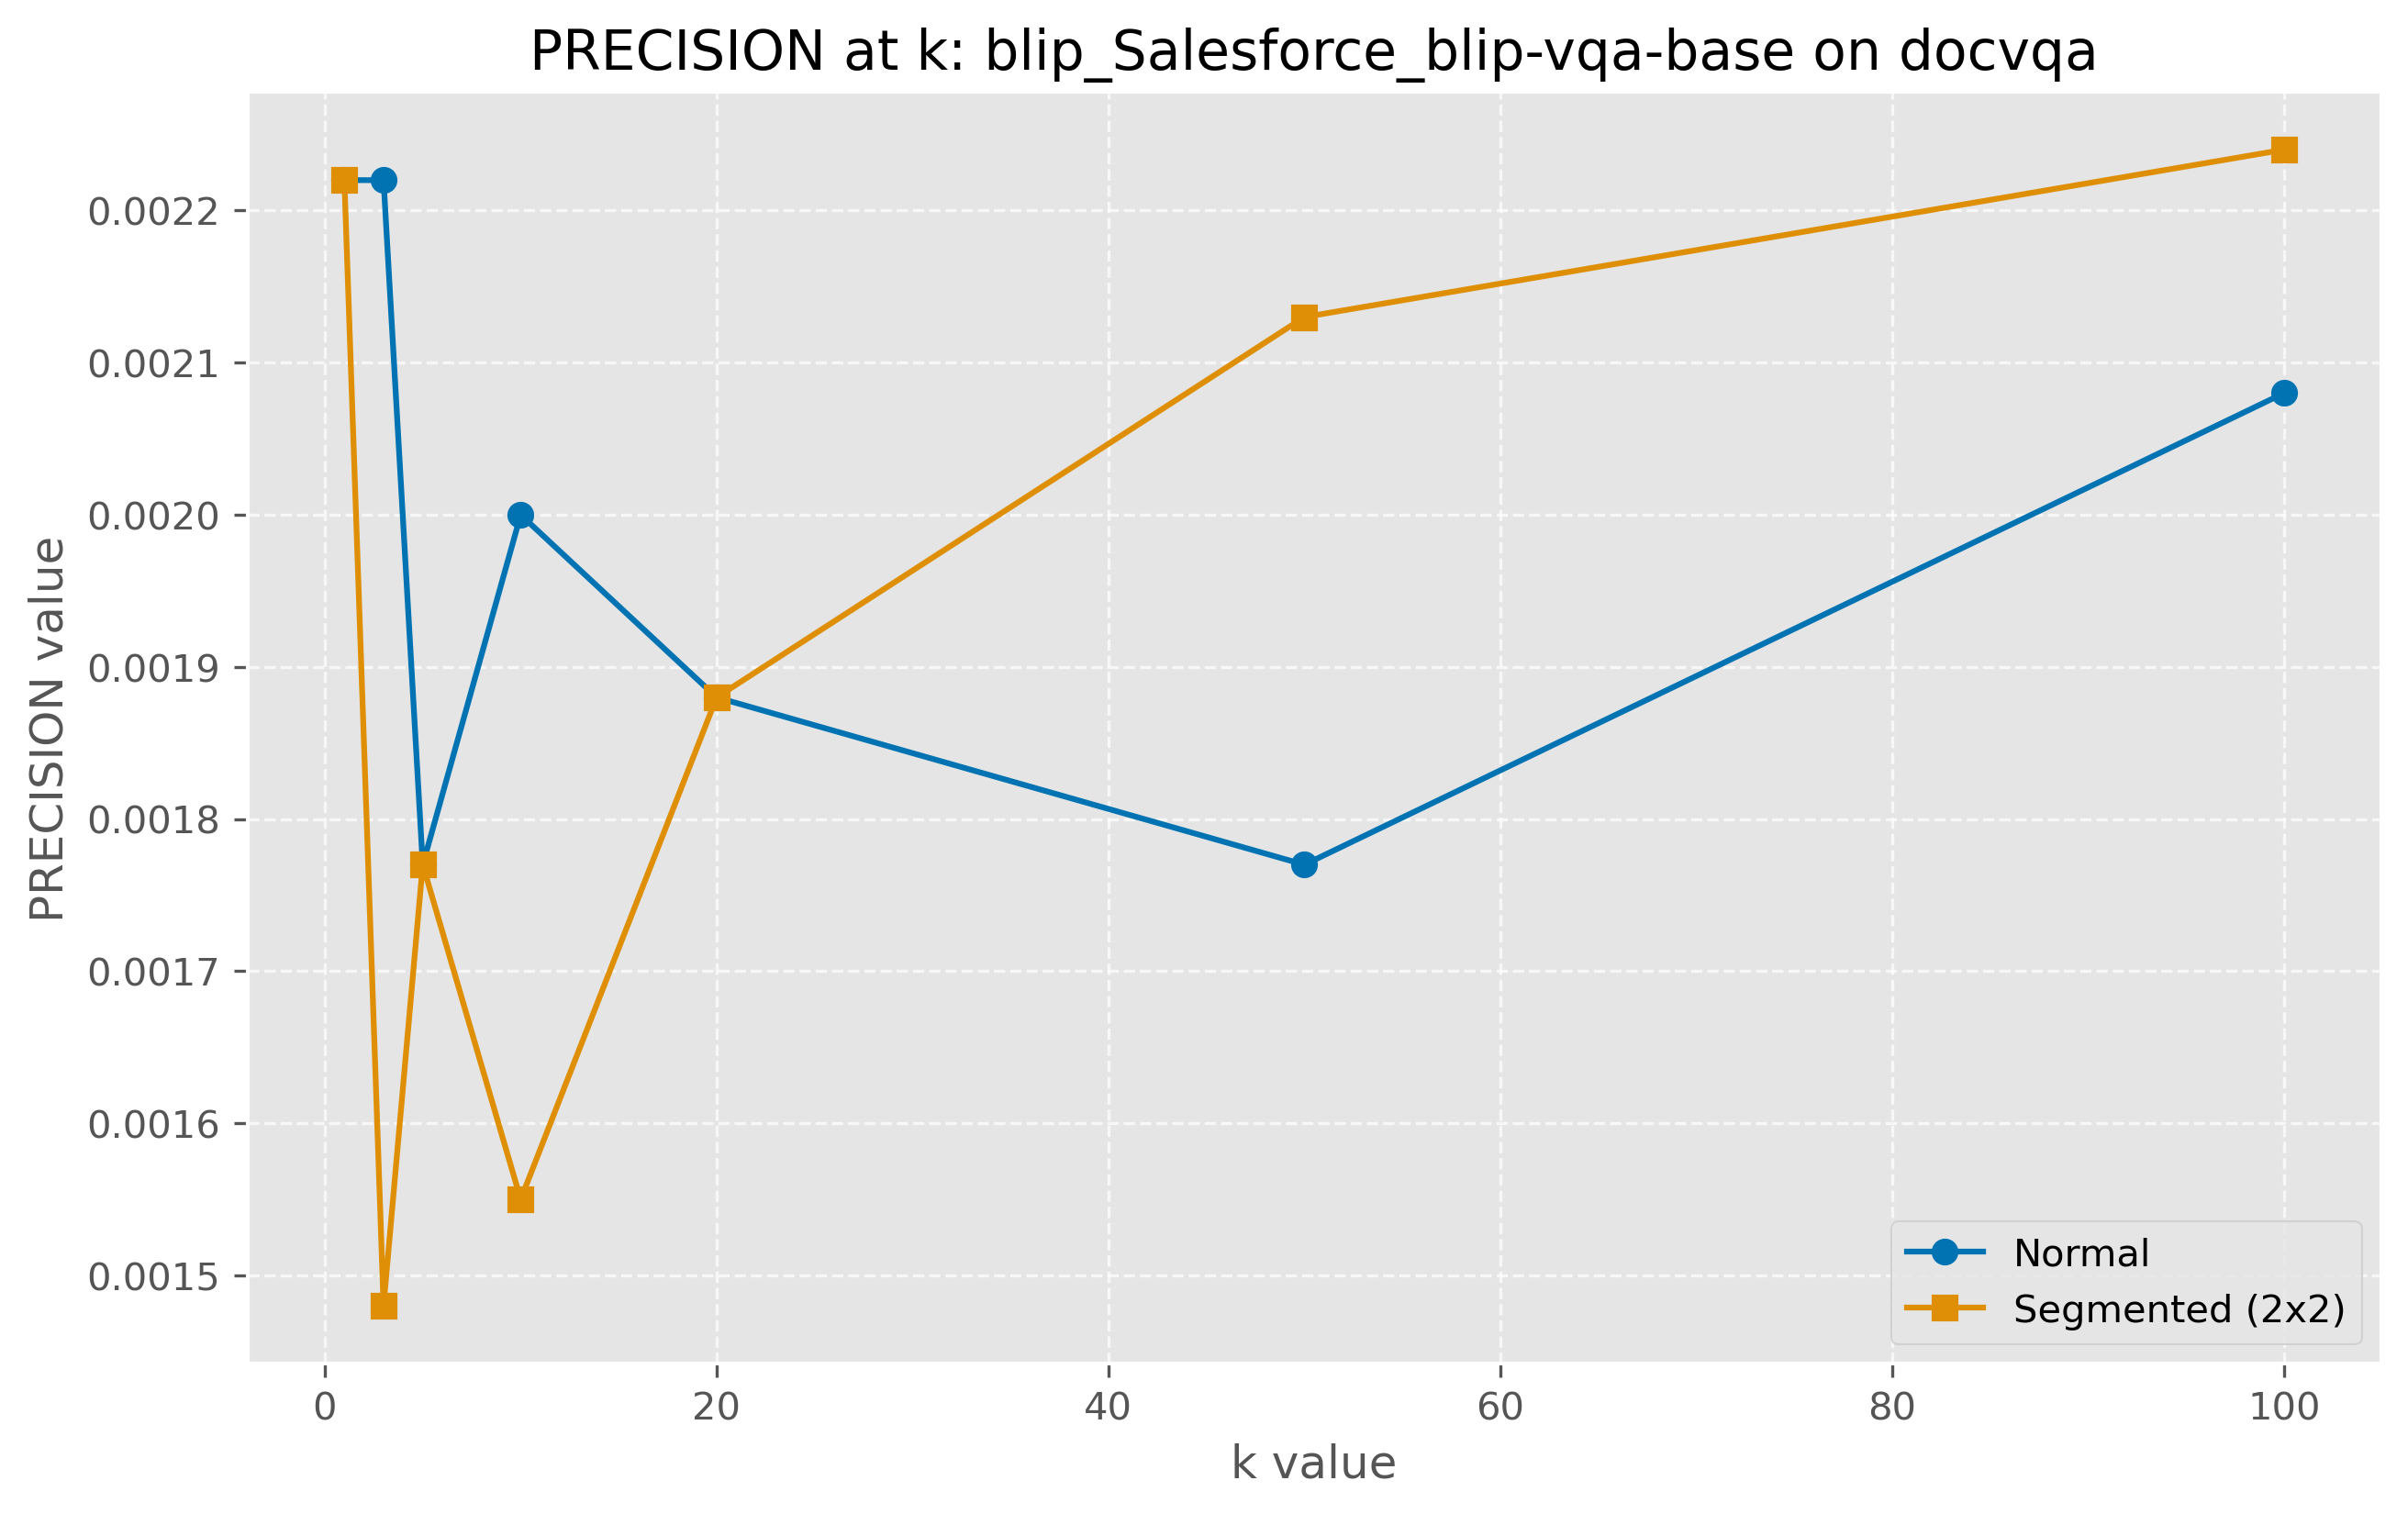


### blip_Salesforce_blip-vqa-base on tabfquad



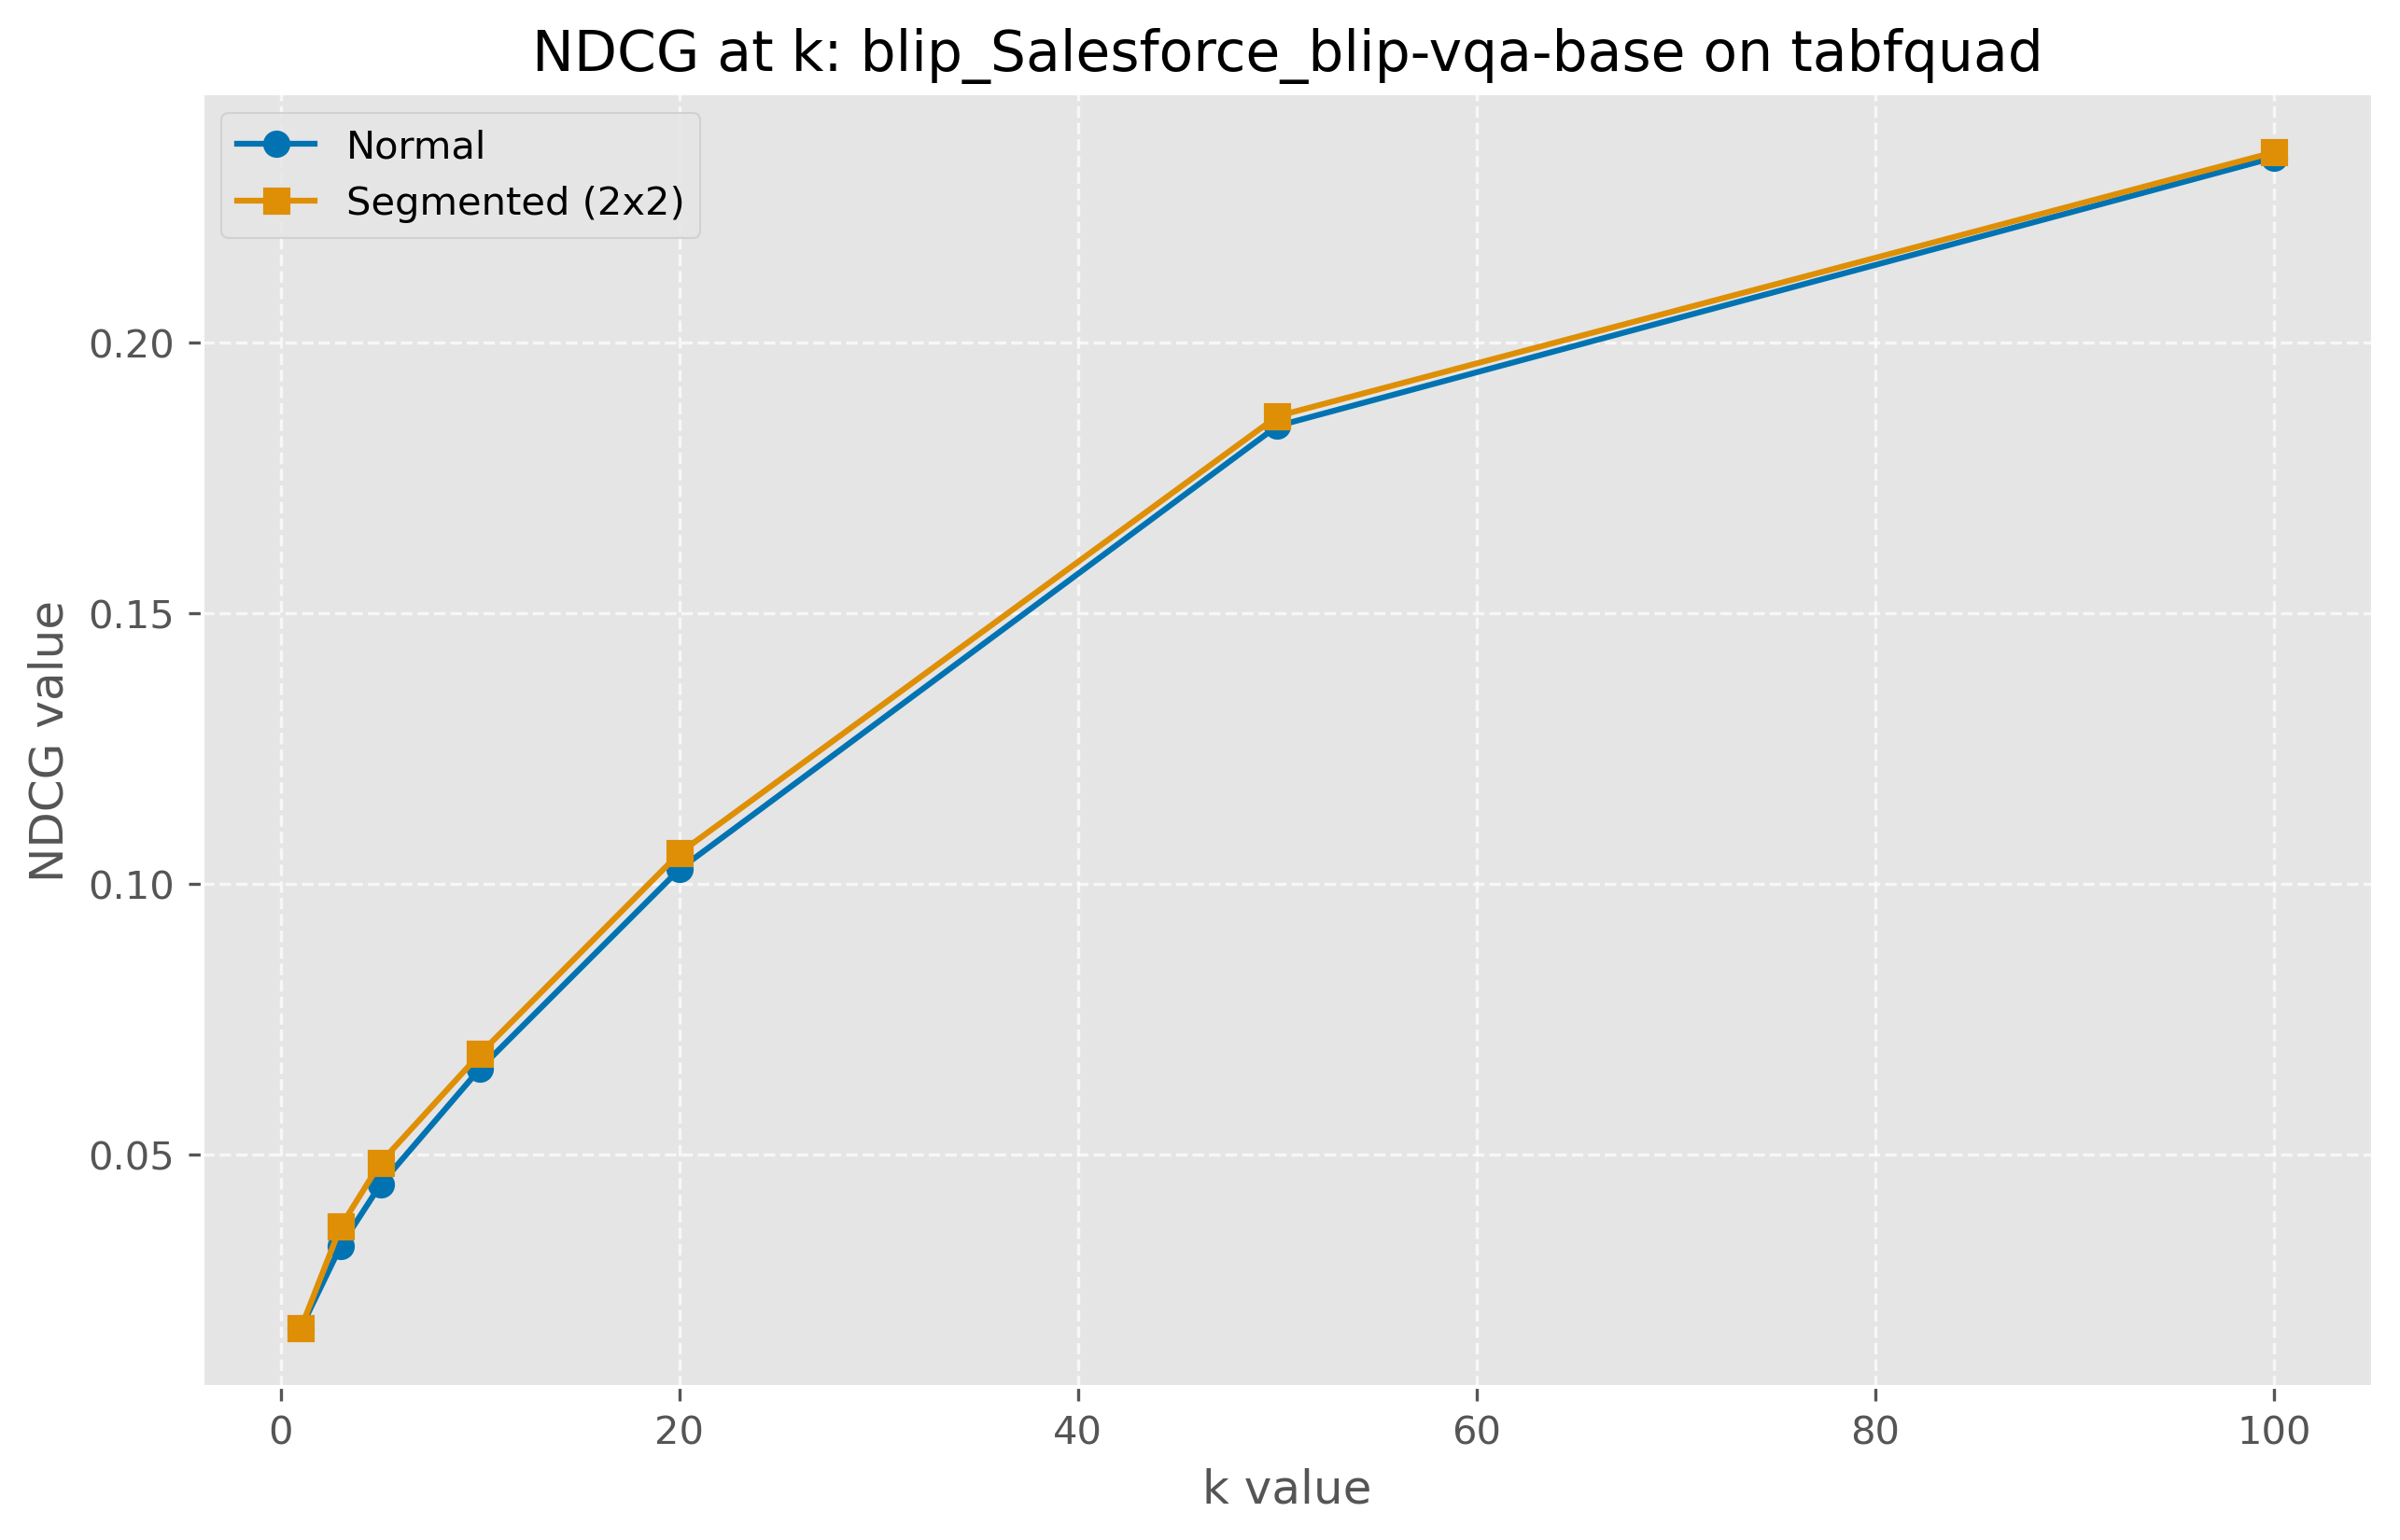

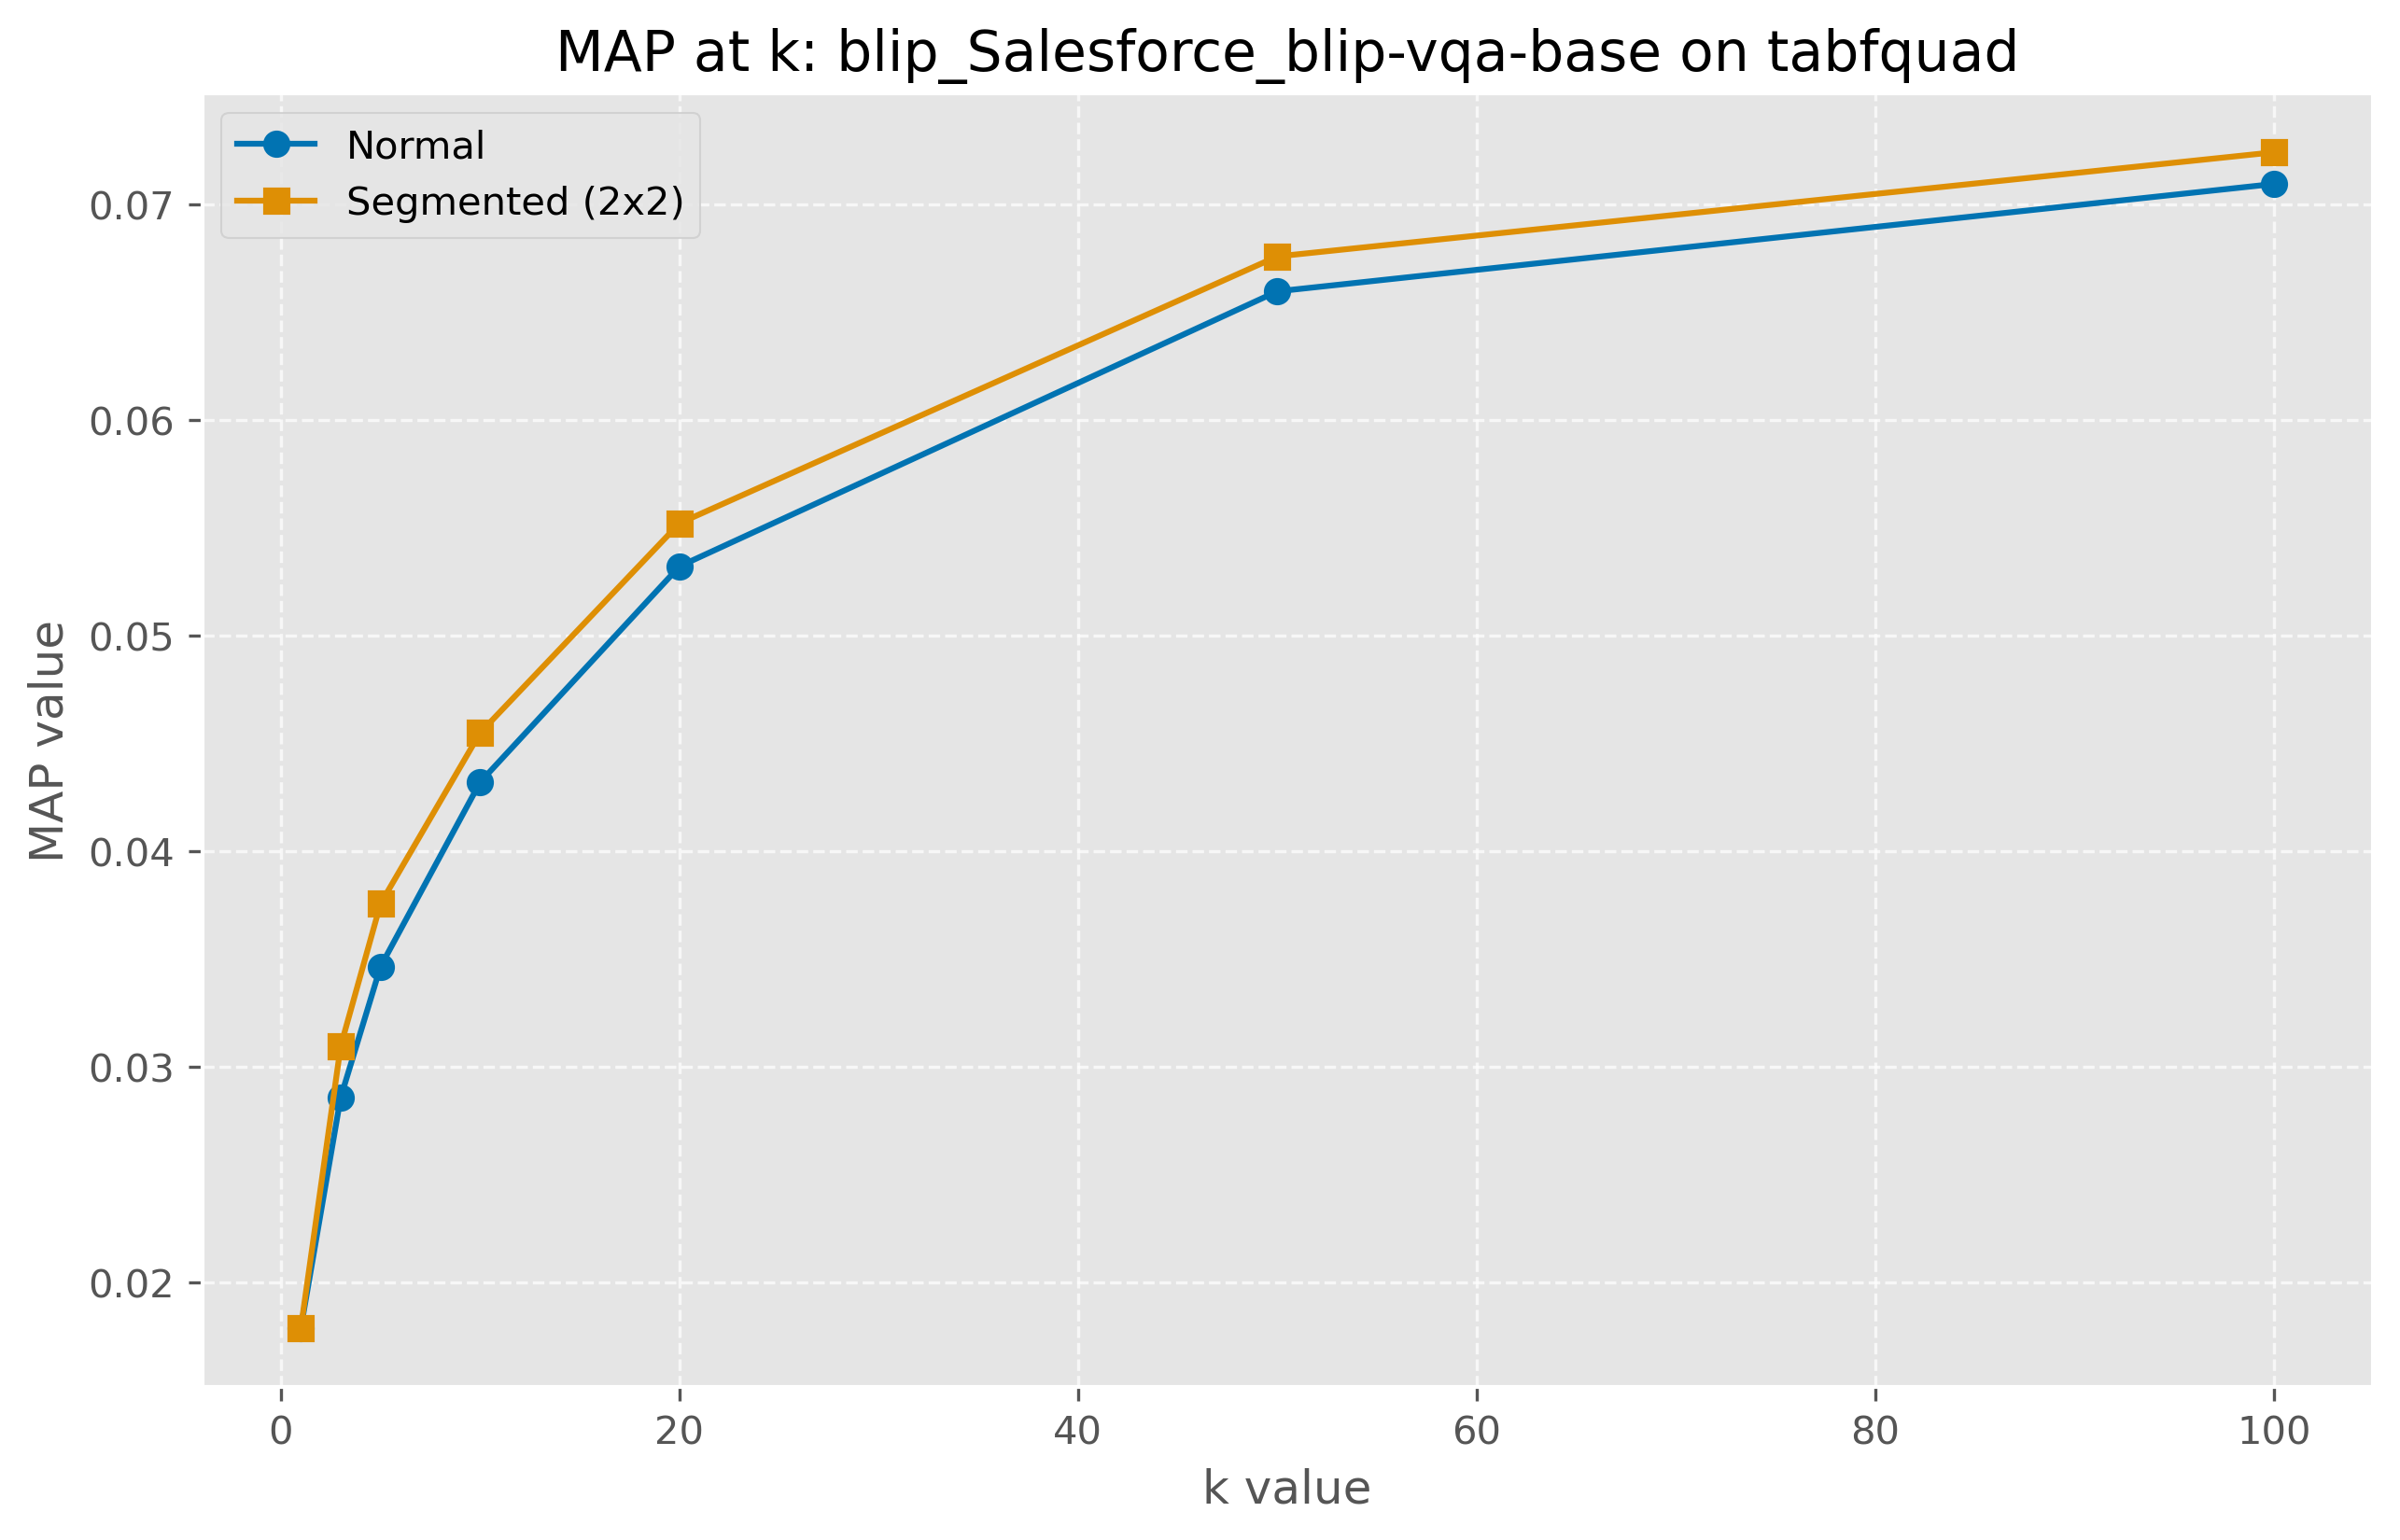

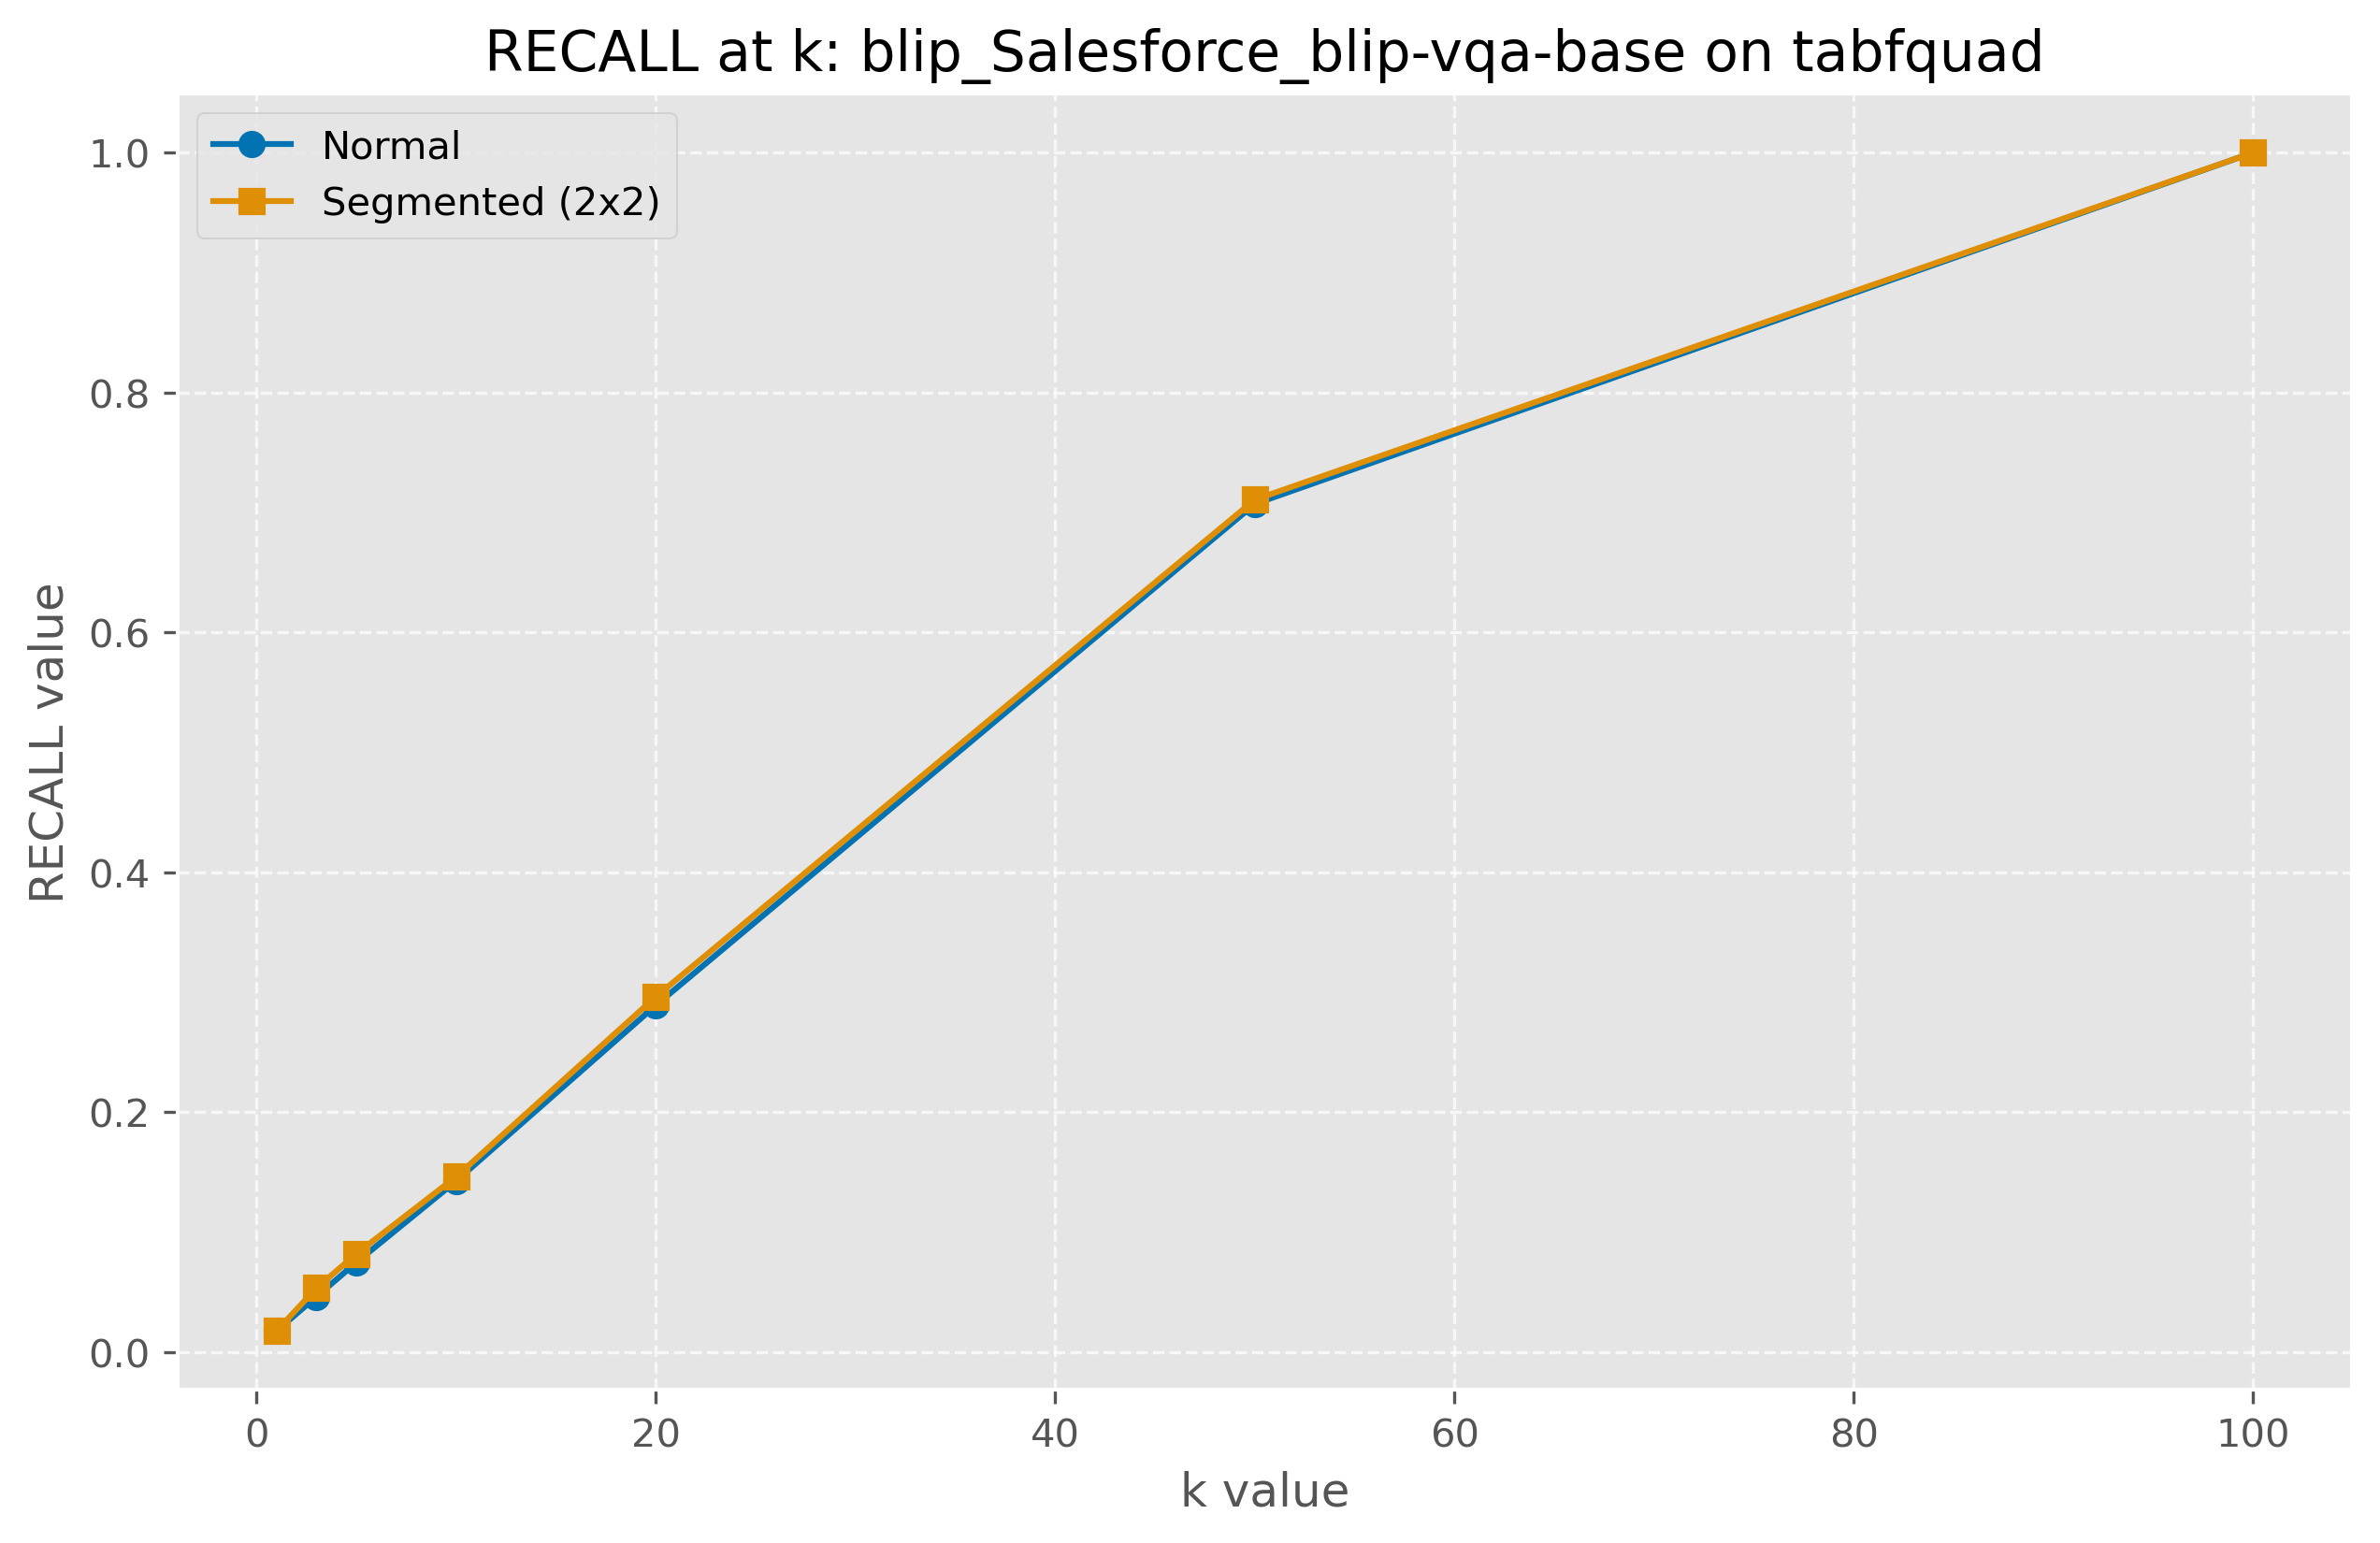

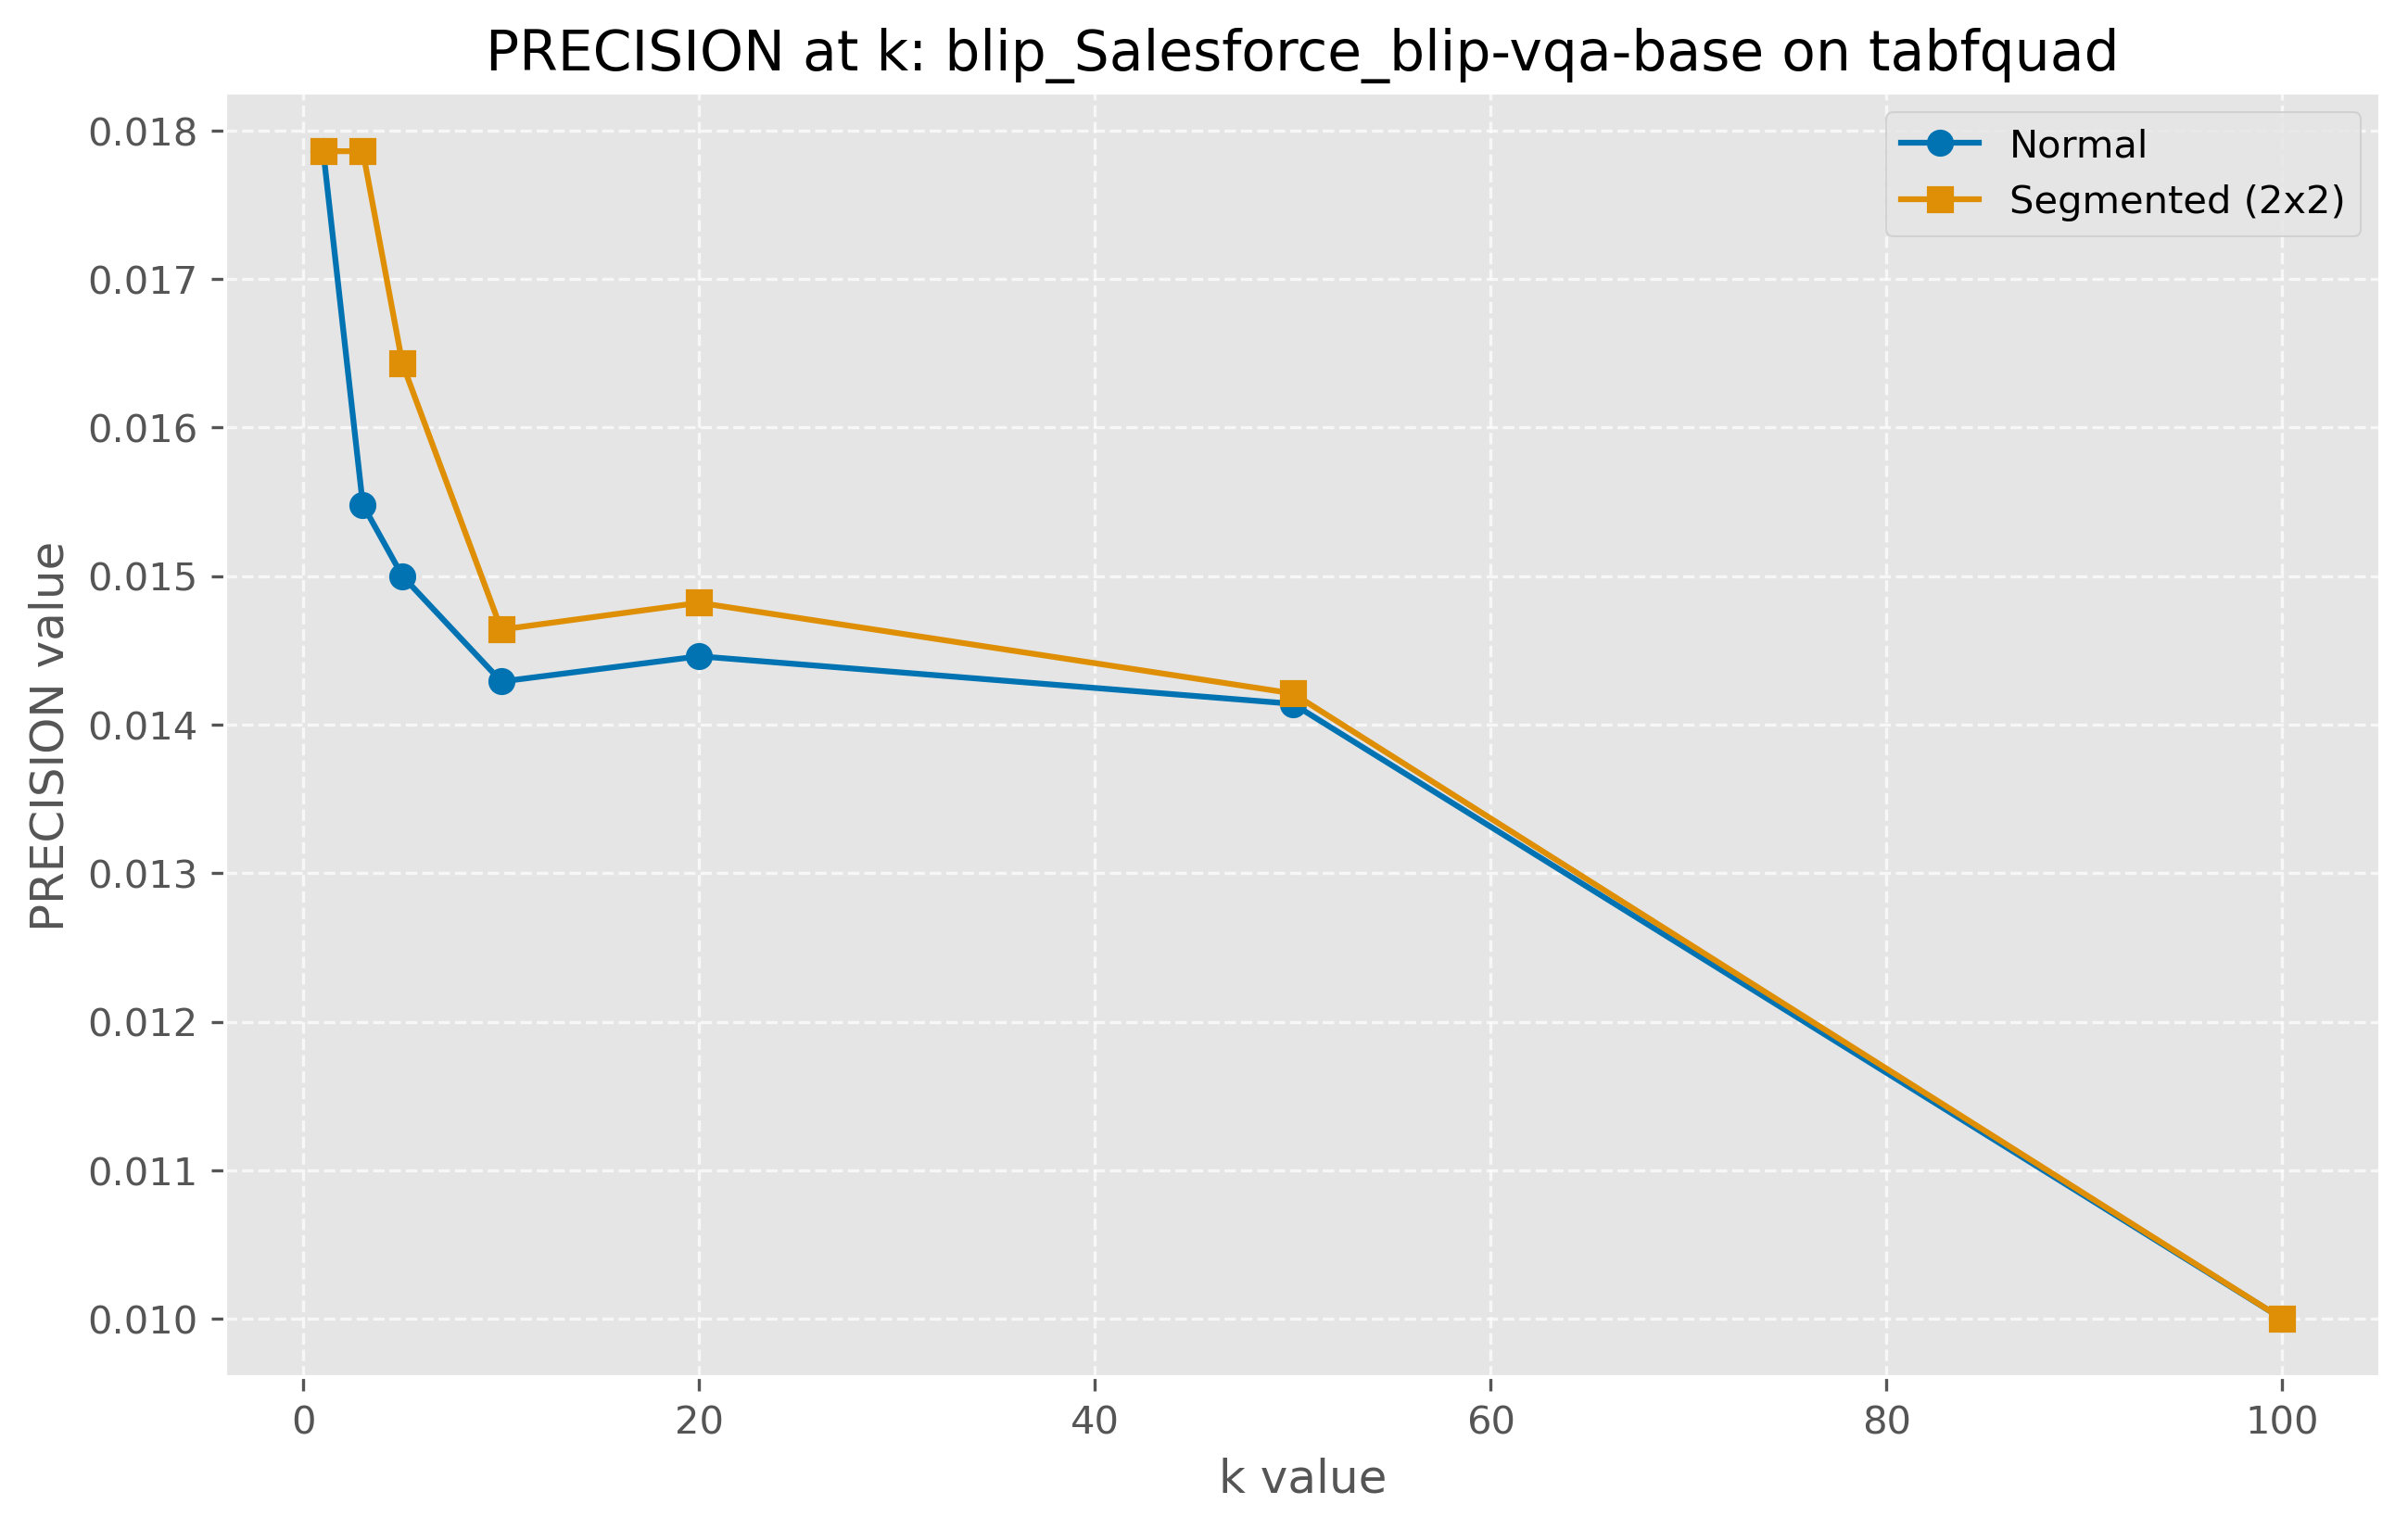

In [52]:
# Get unique model-dataset combinations
model_dataset_pairs = comparison_df[['Base Model', 'Dataset']].drop_duplicates().values

# Plot the first few combinations as examples
for i, (model, dataset) in enumerate(model_dataset_pairs[:3]):
    print(f"\n### {model} on {dataset}\n")
    
    for metric in metric_types:
        plot_model_comparison(model, dataset, metric)

### Effect of Different Segmentation Patterns

In [53]:
# Check if we have multiple segmentation patterns to compare
segmentation_patterns = comparison_df['Segmentation Pattern'].dropna().unique()
print(f"Available segmentation patterns: {segmentation_patterns}")

if len(segmentation_patterns) > 1:
    # Calculate average improvement by segmentation pattern
    pattern_improvement = comparison_df.dropna(subset=['Segmentation Pattern']).groupby('Segmentation Pattern')['Improvement (%)'].mean().reset_index()
    
    plt.figure(figsize=(10, 6))
    sns.barplot(data=pattern_improvement, x='Segmentation Pattern', y='Improvement (%)')
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title('Average Performance Improvement by Segmentation Pattern (%)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

Available segmentation patterns: ['2x2']


## Statistical Significance of Improvements

In [54]:
from scipy import stats

# Paired t-test to check if improvements are statistically significant
t_stat, p_value = stats.ttest_rel(comparison_df['Segmented Value'], comparison_df['Normal Value'])

print(f"Paired t-test results:")
print(f"t-statistic: {t_stat:.4f}")
print(f"p-value: {p_value:.4f}")
print(f"{'Statistically significant improvement' if p_value < 0.05 and t_stat > 0 else 'Not statistically significant'} at α=0.05")

Paired t-test results:
t-statistic: 6.4817
p-value: 0.0000
Statistically significant improvement at α=0.05


## Summary of Findings

In [55]:
# Calculate overall percentage of cases where segmentation improves performance
improvement_count = (comparison_df['Improvement (%)'] > 0).sum()
total_count = len(comparison_df)
improvement_percentage = improvement_count / total_count * 100

print(f"Segmentation improves performance in {improvement_percentage:.2f}% of cases ({improvement_count} out of {total_count})")

# Calculate average improvement across all metrics
avg_improvement = comparison_df['Improvement (%)'].mean()
print(f"Average performance improvement: {avg_improvement:.2f}%")

# Identify the best and worst cases
best_case = comparison_df.loc[comparison_df['Improvement (%)'].idxmax()]
worst_case = comparison_df.loc[comparison_df['Improvement (%)'].idxmin()]

print("\nBest improvement case:")
print(f"  Model: {best_case['Base Model']}")
print(f"  Dataset: {best_case['Dataset']}")
print(f"  Metric: {best_case['Metric']} at k={best_case['k']}")
print(f"  Improvement: {best_case['Improvement (%)']:.2f}%")

print("\nWorst case:")
print(f"  Model: {worst_case['Base Model']}")
print(f"  Dataset: {worst_case['Dataset']}")
print(f"  Metric: {worst_case['Metric']} at k={worst_case['k']}")
print(f"  Degradation: {worst_case['Improvement (%)']:.2f}%")

Segmentation improves performance in 55.36% of cases (310 out of 560)
Average performance improvement: 32.97%

Best improvement case:
  Model: jina-clip-v1_jinaai_jina-clip-v1
  Dataset: tatdqa
  Metric: ndcg at k=1
  Improvement: 580.57%

Worst case:
  Model: llava-interleave_llava-hf_llava-interleave-qwen-0.5b-hf
  Dataset: arxivqa
  Metric: recall at k=3
  Degradation: -75.00%


## Conclusion

This analysis compares the performance of models using normal image input versus segmented image input. The key findings are:

1. **Overall Impact**: [Fill in based on results - whether segmentation generally helps or hurts]
2. **Dataset-Specific Effects**: [Fill in which datasets benefit most from segmentation]
3. **Model-Specific Effects**: [Fill in which models benefit most from segmentation]
4. **Metric-Specific Effects**: [Fill in which metrics show most improvement]
5. **Segmentation Pattern Effects**: [Fill in how different segmentation patterns compare]

These findings can help guide decisions about when to use image segmentation in document visual question answering tasks.